In [2]:
import matplotlib.pyplot as plt
import pandas as pd

C:\Users\carlv\AppData\Local\Temp\ipykernel_34268\1505719282.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [17]:
paths = ['pics/v1', 'pics/v2', 'pics/v3']
titles = ['PV-Wind-BESS', 'Hydro-BESS-SC', 'Hydro-Wind-BESS-SC']
my_names = [x.split('-') for x in titles]
services = ['FCR', 'FFR', 'FFR-FCR', 'FCR-D']

Running for  PV-Wind-BESS
Running for  Hydro-BESS-SC
Running for  Hydro-Wind-BESS-SC


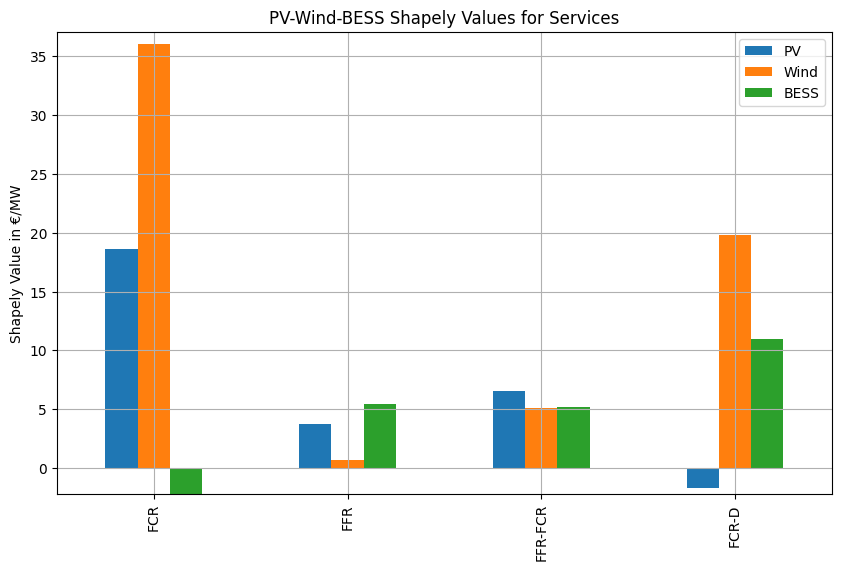

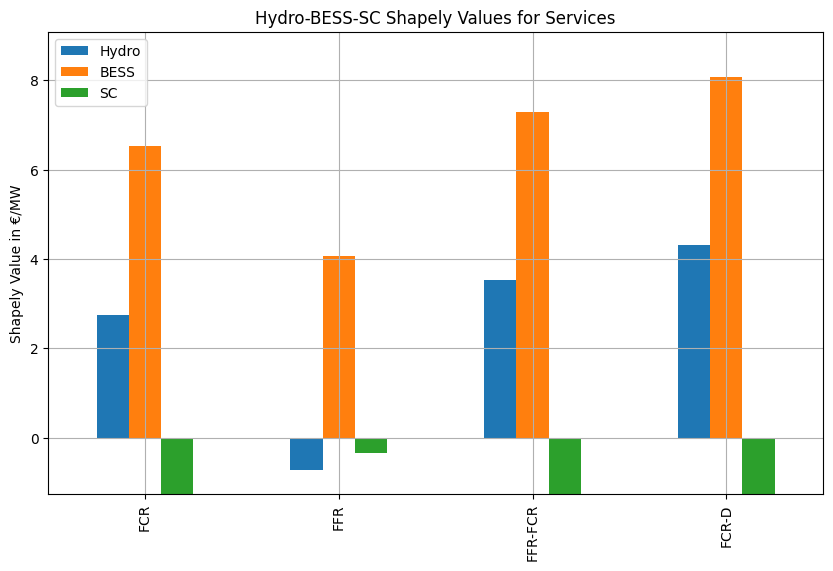

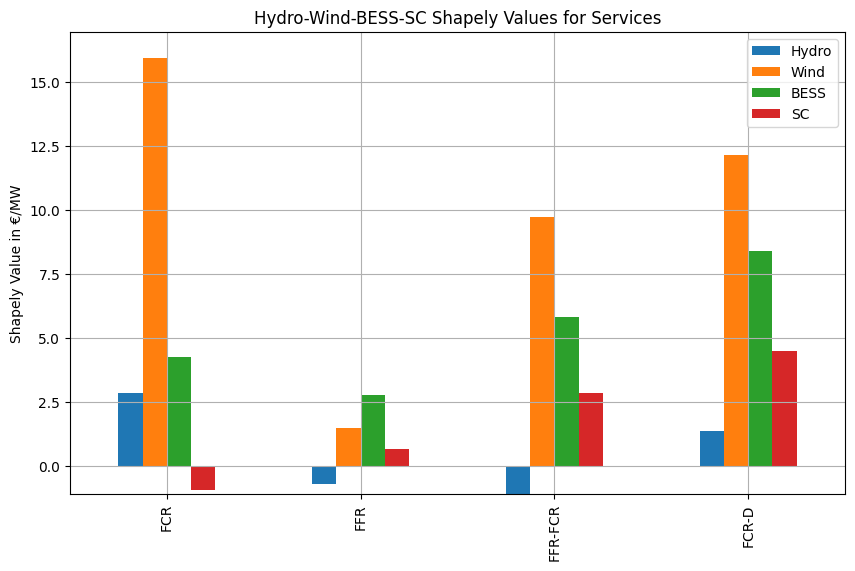

In [28]:
for path, tit, ma_name in zip(paths, titles, my_names):
    print('Running for ', tit)
    df_tot = pd.DataFrame(index=services, columns=ma_name)
    for service in services:
        # do same for reward and shapely values values
        subpath = service.replace('-','_')
        try:
            df = pd.read_csv(f'{path}/{subpath}/shapely_values_{service}.csv', index_col=0)
        except:
            continue
        # df = df.groupby(df.index).first()
        # df = df.transpose()
        # df.sort_index(axis=1, inplace=True)
        if len(df)>1:
            # take mean and insert in df_tot
            df_tot.loc[service] = df.mean(axis=0)
            # add std.
            # df_tot.loc[service + '_std'] = df.std(axis=0)
        else:
            df_tot.loc[service] = df.iloc[0]
        # change lables
    df_tot.plot(
            kind='bar', figsize=(10, 6),
            title=f'{tit} Shapely Values for Services', ylabel='Shapely Value in €/MW')
    plt.grid()
    plt.ylim(df_tot.min().min(), df_tot.max().max()+1)

In [ ]:
path = 'pics/DVPP2'
services = ['FCR', 'FFR', 'FFR_FCR', 'FCR_D']
# df = pd.read_csv('data/energy_provision.csv', index_col=0)
service = services[0]

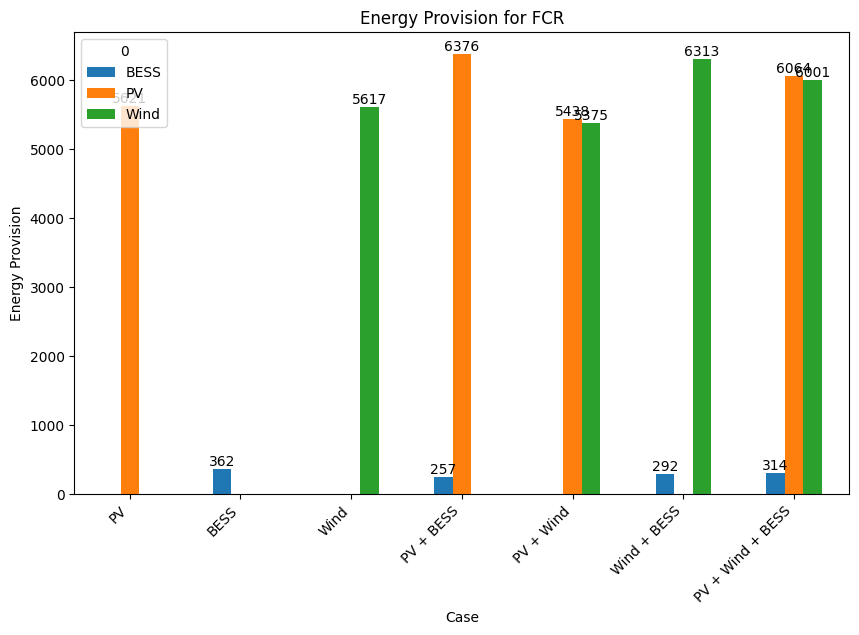

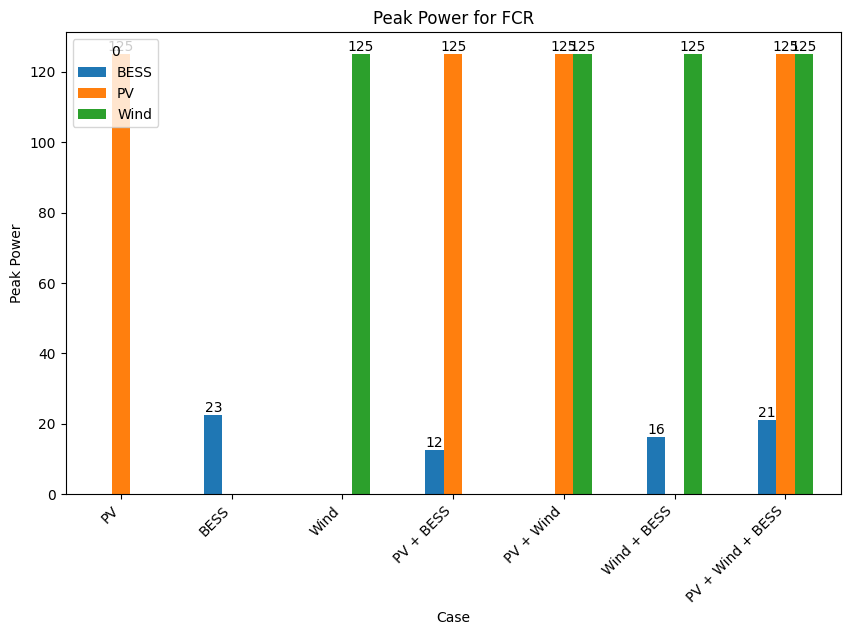

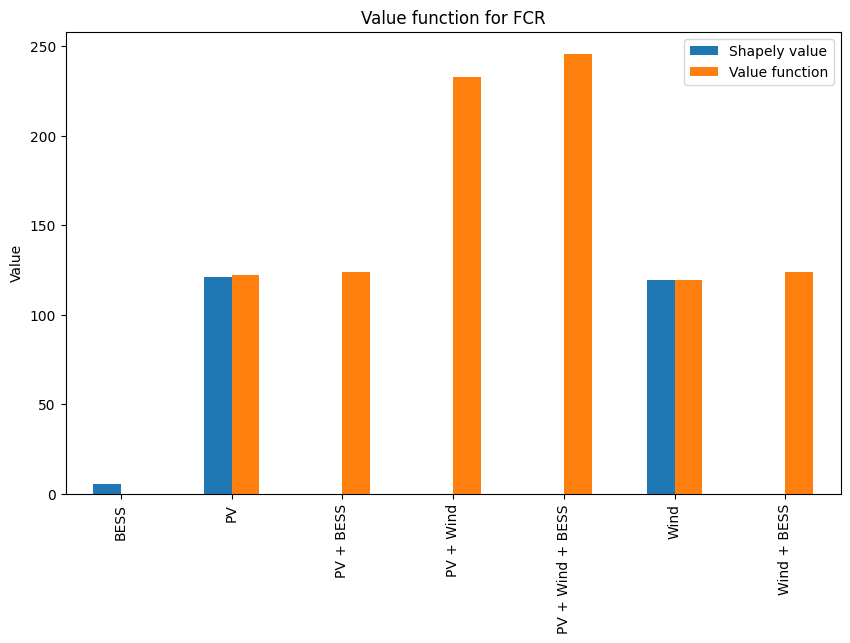

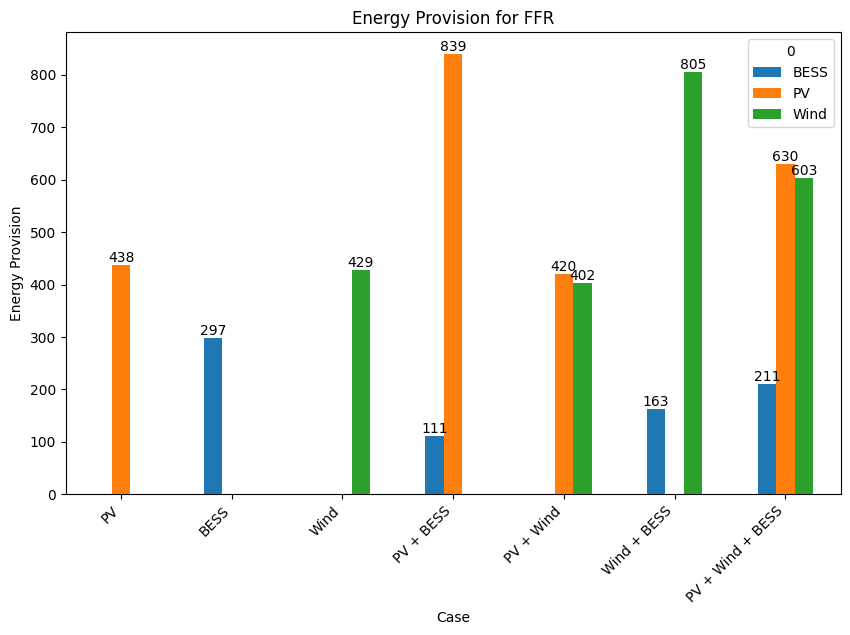

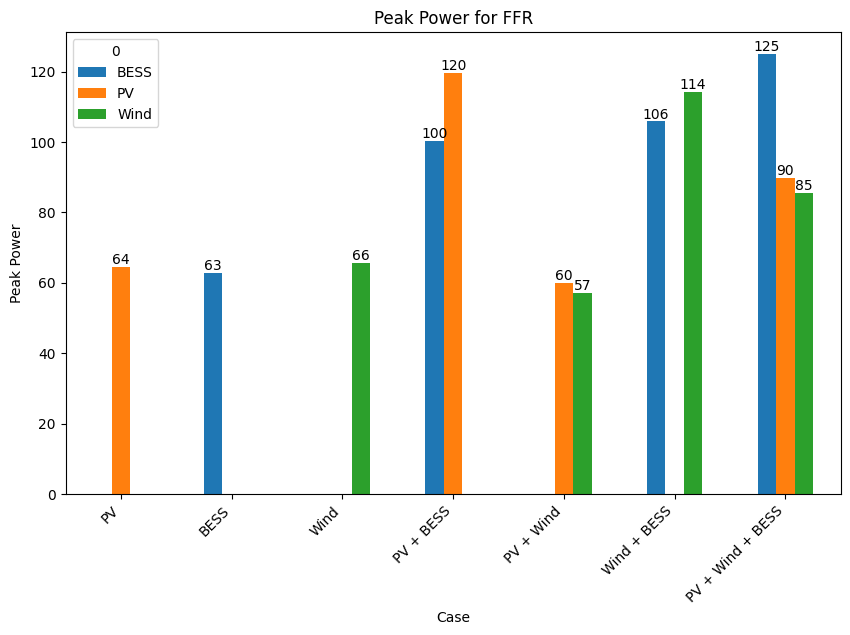

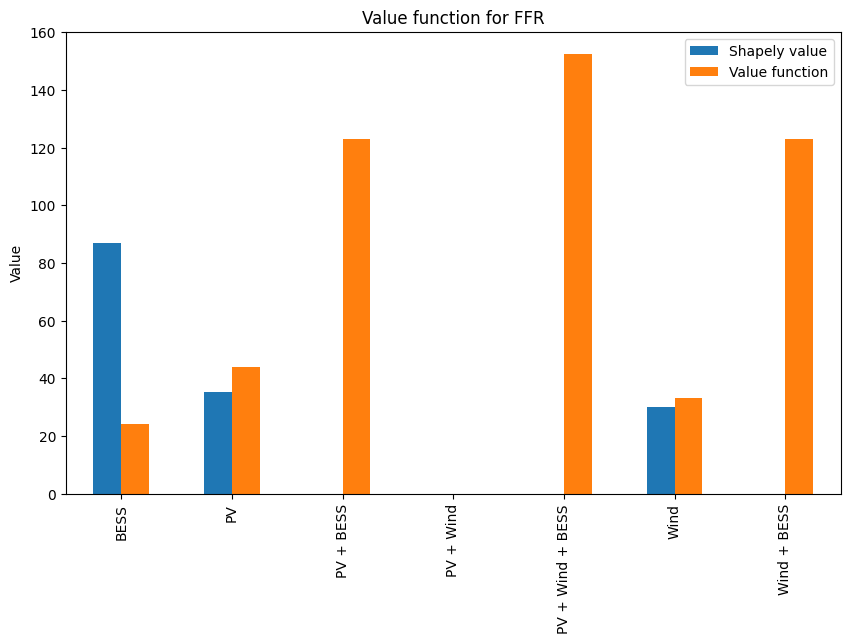

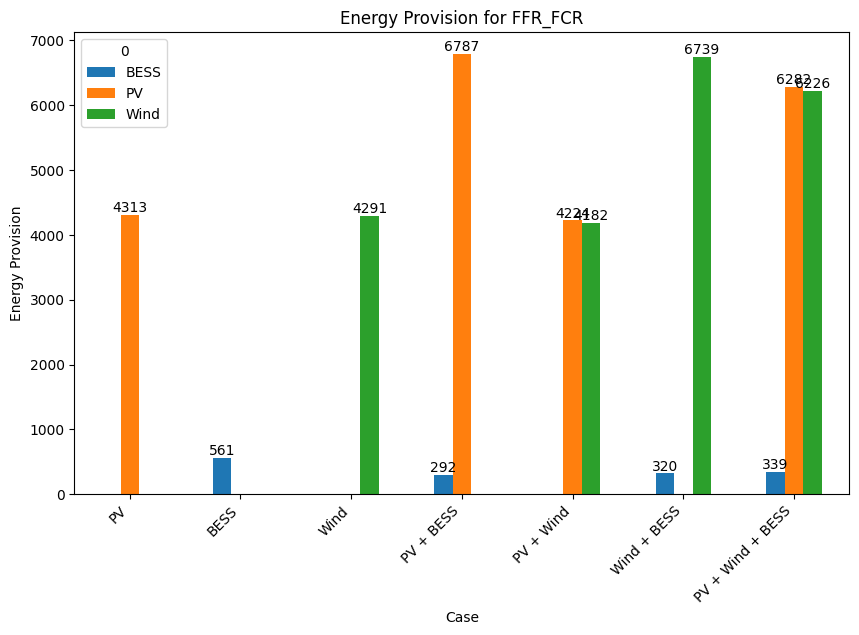

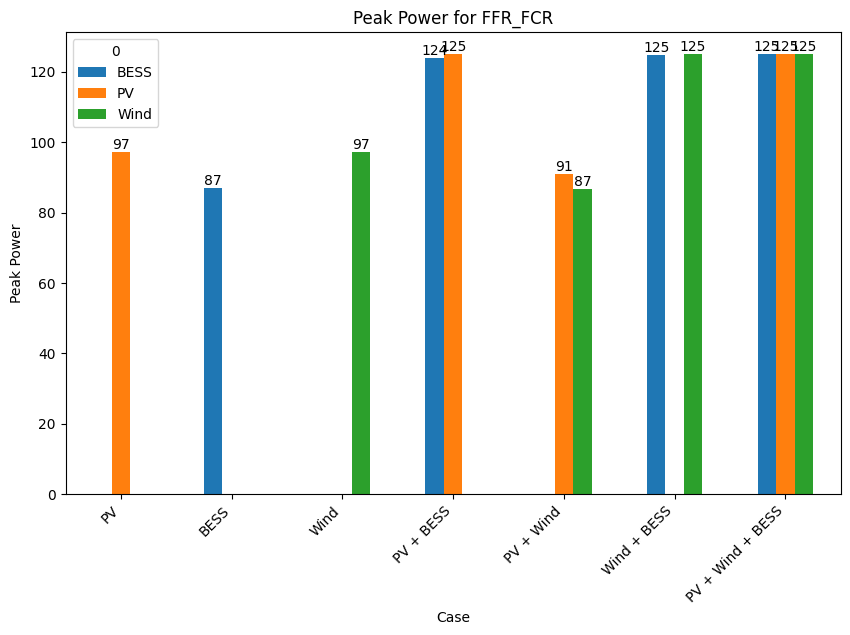

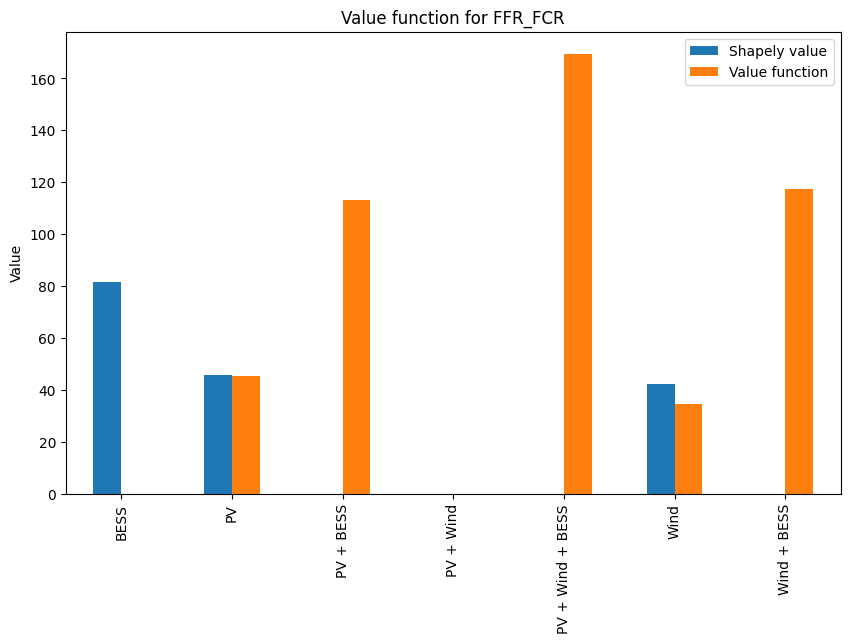

In [23]:
for service in services:
    df = pd.read_csv(f'{path}/{service}/energy_provision.csv', index_col=0)
    # modify to include only rows not containing '+'
    df = df[~df.index.str.contains('\+')]
    # move indexes into first 3 indexes with start with same first character
    df.index = df.index.str.extract('([A-Za-z]+)')[0]
    df = df.groupby(df.index).first()
    df = df.transpose()
    # df.fillna(0)
    # make grouped bar chart for each column
    ax = df.plot(kind='bar', figsize=(10, 6),
                title=f'Energy Provision for {service}', ylabel='Energy Provision', xlabel='Case')
    plt.xticks(rotation=45, ha='right')
    # show numbers above bars
    for p in ax.patches:
        if p.get_height() > 0:
            ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2, p.get_height()),
                        ha='center', va='bottom')
    plt.show()

    # do same for peak power
    df = pd.read_csv(f'{path}/{service}/peak_power.csv', index_col=0)
    # modify to include only rows not containing '+'
    df = df[~df.index.str.contains('\+')]
    # move indexes into first 3 indexes with start with same first character
    df.index = df.index.str.extract('([A-Za-z]+)')[0]
    df = df.groupby(df.index).first()
    df = df.transpose()
    # df.fillna(0)
    # make grouped bar chart for each column
    ax = df.plot(kind='bar', figsize=(10, 6),
                title=f'Peak Power for {service}', ylabel='Peak Power', xlabel='Case')
    plt.xticks(rotation=45, ha='right')
    # show numbers above bars
    for p in ax.patches:
        if p.get_height() > 0:
            ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2, p.get_height()),
                        ha='center', va='bottom')
    plt.show()

    # do same for reward and shapely values values
    df = pd.read_csv(f'{path}/{service}/value_function.csv', index_col=0)
    df = df.groupby(df.index).first()
    df = df.transpose()

    df_2 = pd.read_csv(f'{path}/{service}/shapely_value.csv', index_col=0)
    df_2 = df_2.groupby(df_2.index).first()
    df_2 = df_2.transpose()
    # merge df_2 into df where index match
    df = pd.merge(df, df_2, left_index=True, right_index=True, how='outer')
    df.columns = ['Value function', 'Shapely value']
    df.sort_index(axis=1, inplace=True)
    # change lables
    df.plot(kind='bar', figsize=(10, 6),
            title=f'Value function for {service}', ylabel='Value')

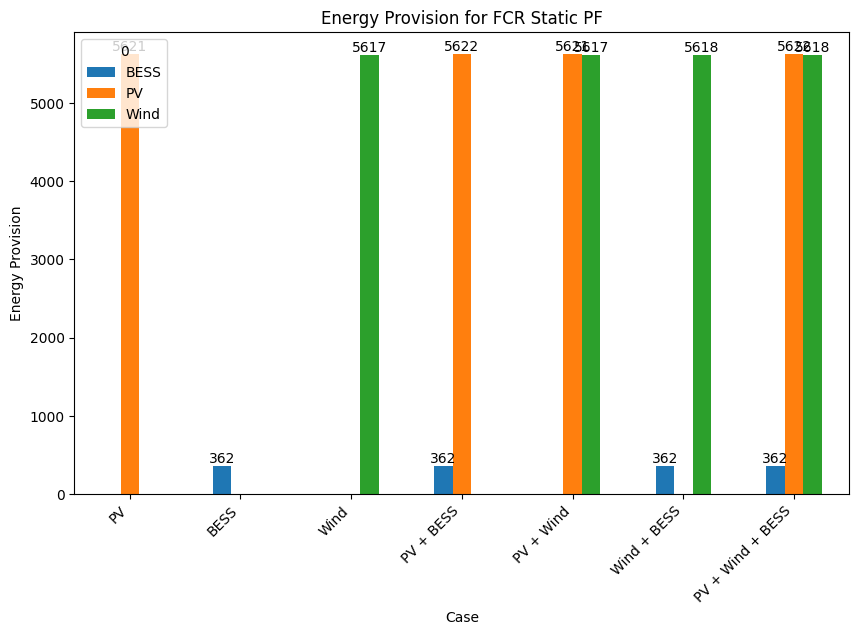

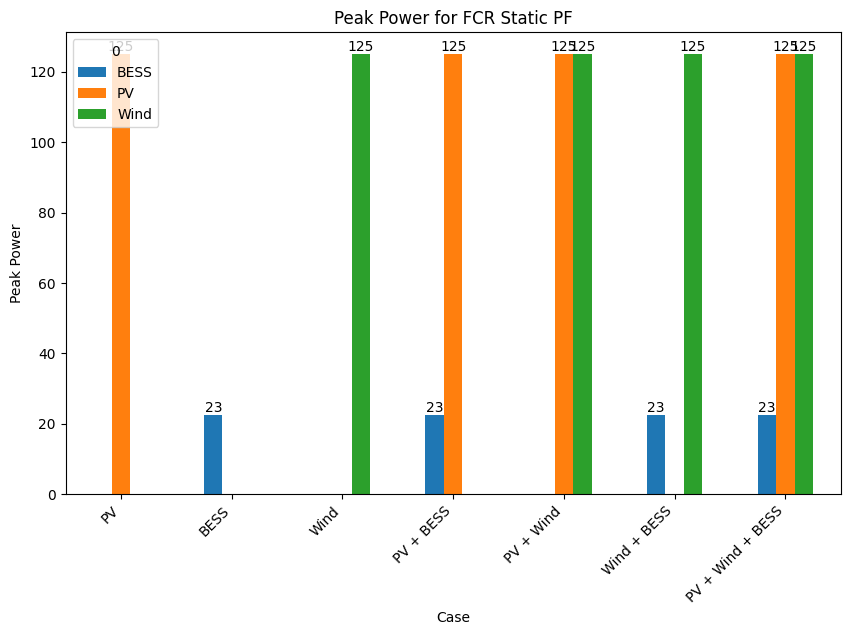

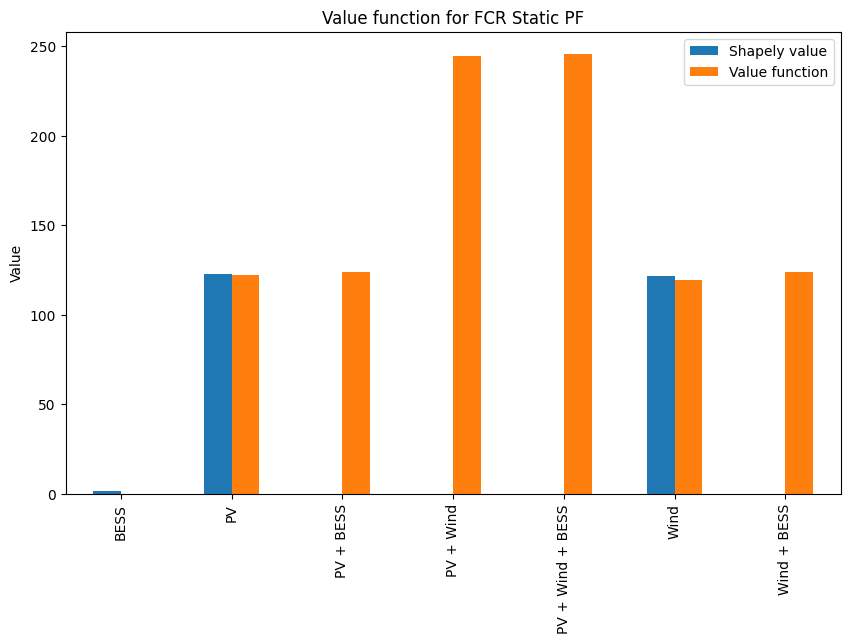

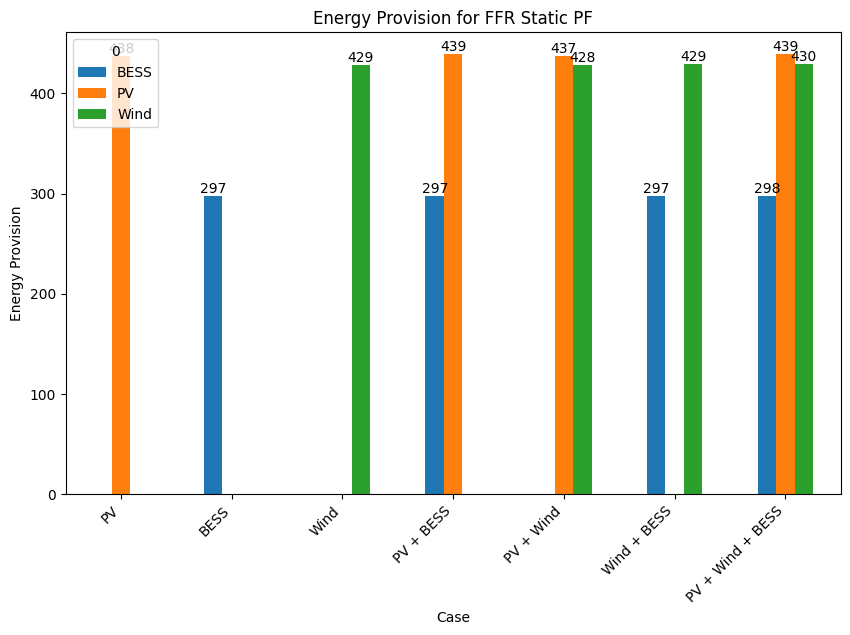

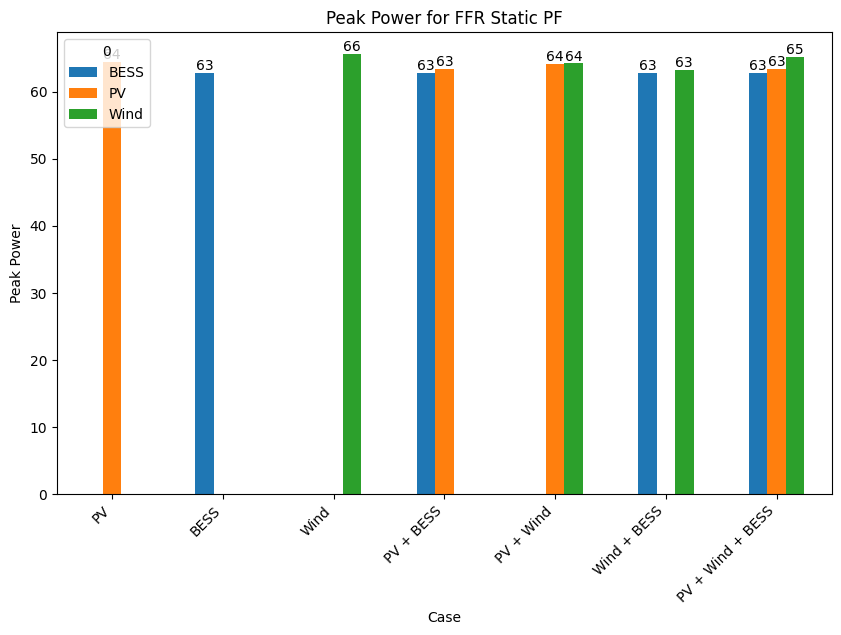

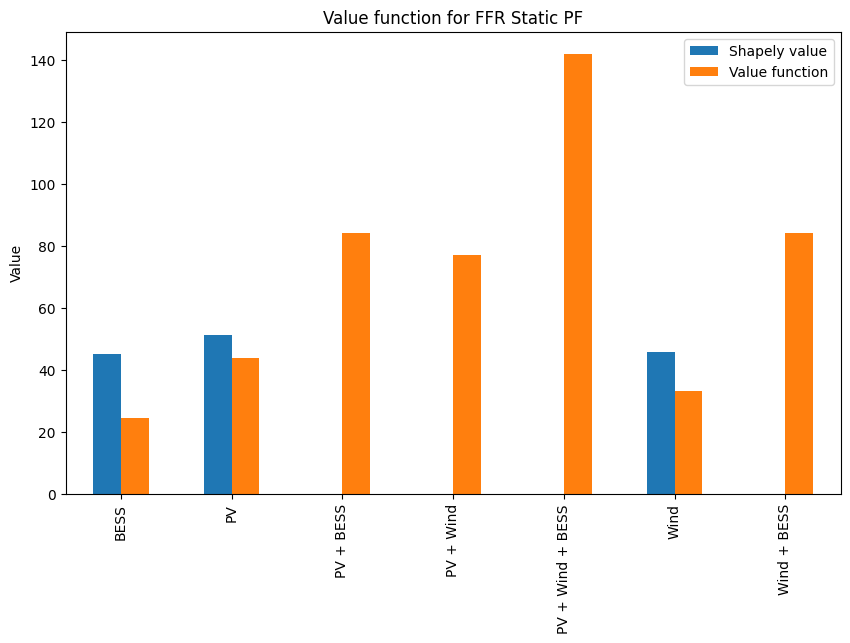

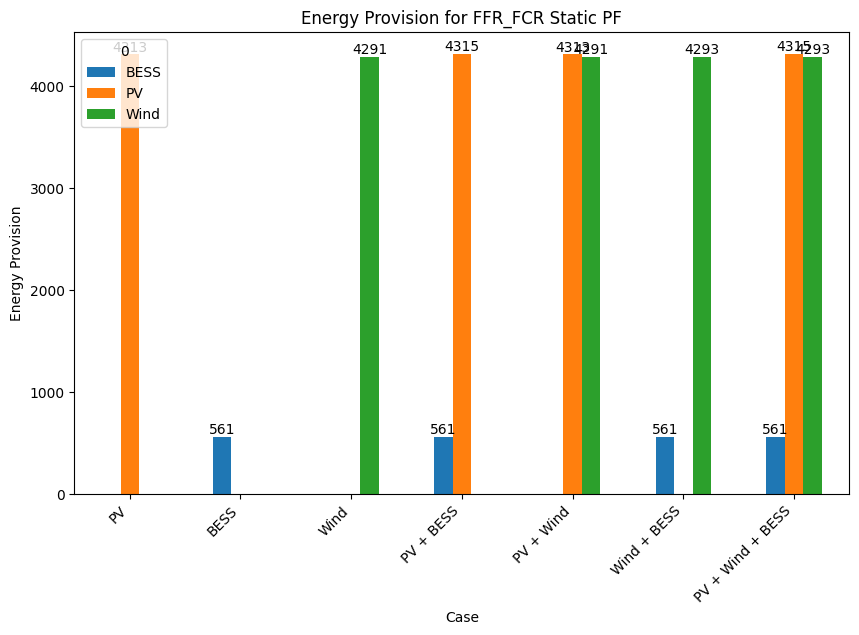

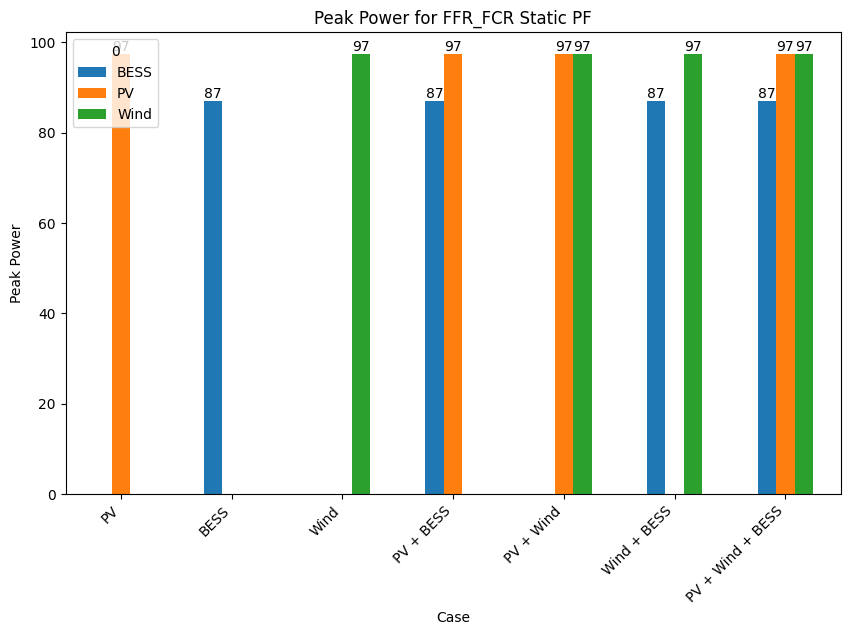

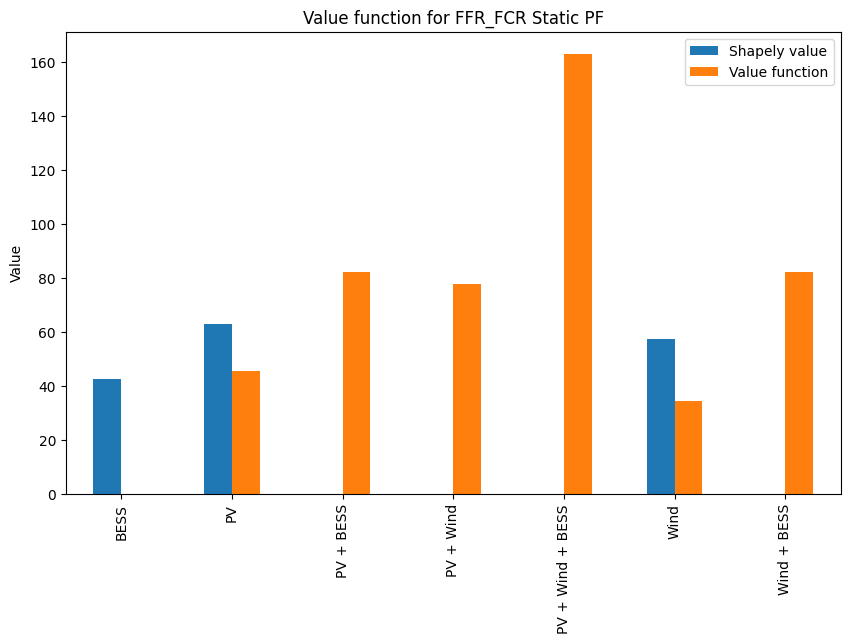

In [24]:
# do same for static pf

for service in services:
    df = pd.read_csv(f'{path}/{service}/energy_provision_static_pf.csv', index_col=0)
    # modify to include only rows not containing '+'
    df = df[~df.index.str.contains('\+')]
    # move indexes into first 3 indexes with start with same first character
    df.index = df.index.str.extract('([A-Za-z]+)')[0]
    df = df.groupby(df.index).first()
    df = df.transpose()
    # df.fillna(0)
    # make grouped bar chart for each column
    ax = df.plot(kind='bar', figsize=(10, 6),
                title=f'Energy Provision for {service} Static PF', ylabel='Energy Provision', xlabel='Case')
    plt.xticks(rotation=45, ha='right')
    # show numbers above bars
    for p in ax.patches:
        if p.get_height() > 0:
            ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2, p.get_height()),
                        ha='center', va='bottom')
    plt.show()

    # do same for peak power
    df = pd.read_csv(f'{path}/{service}/peak_power_static_pf.csv', index_col=0)
    # modify to include only rows not containing '+'
    df = df[~df.index.str.contains('\+')]
    # move indexes into first 3 indexes with start with same first character
    df.index = df.index.str.extract('([A-Za-z]+)')[0]
    df = df.groupby(df.index).first()
    df = df.transpose()
    # df.fillna(0)
    # make grouped bar chart for each column
    ax = df.plot(kind='bar', figsize=(10, 6),
                title=f'Peak Power for {service} Static PF', ylabel='Peak Power', xlabel='Case')
    plt.xticks(rotation=45, ha='right')
    # show numbers above bars
    for p in ax.patches:
        if p.get_height() > 0:
            ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2, p.get_height()),
                        ha='center', va='bottom')
    plt.show()

    # do same for reward and shapely values values
    df = pd.read_csv(f'{path}/{service}/value_function_static_pf.csv', index_col=0)
    df = df.groupby(df.index).first()
    df = df.transpose()

    df_2 = pd.read_csv(f'{path}/{service}/shapely_value_static_pf.csv', index_col=0)
    df_2 = df_2.groupby(df_2.index).first()
    df_2 = df_2.transpose()
    # merge df_2 into df where index match
    df = pd.merge(df, df_2, left_index=True, right_index=True, how='outer')
    df.columns = ['Value function', 'Shapely value']
    df.sort_index(axis=1, inplace=True)
    # change lables
    df.plot(kind='bar', figsize=(10, 6),
            title=f'Value function for {service} Static PF', ylabel='Value')

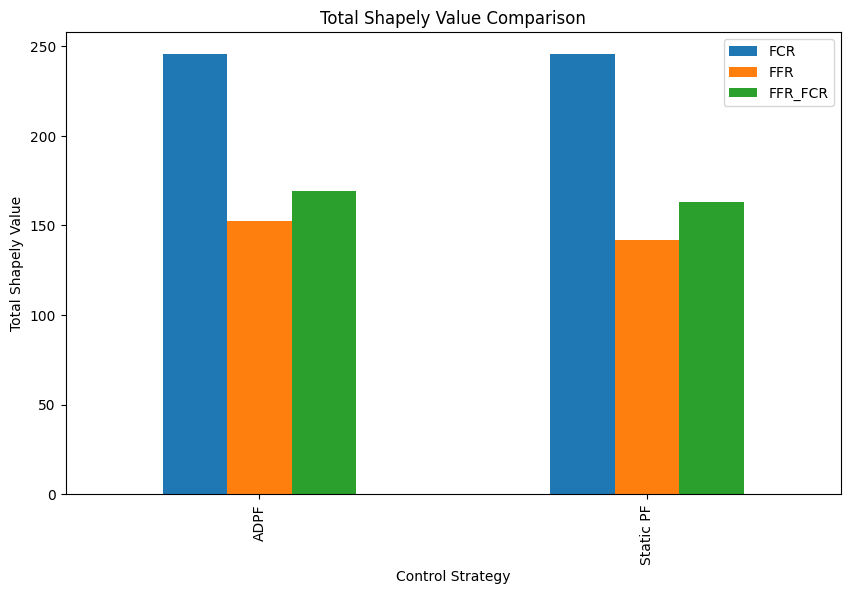

In [ ]:
# # compare  static pf and adpf total summed shapely value for all services
# df_final = pd.DataFrame(columns=services, index=['ADPF', 'Static PF'])
# for service in services:
#     df = pd.read_csv(f'{path}/{service}/shapely_value.csv', index_col=0)
#     df = df.groupby(df.index).first()
#     df = df.transpose()
#     df_2 = pd.read_csv(f'{path}/{service}/shapely_value_static_pf.csv', index_col=0)
#     df_2 = df_2.groupby(df_2.index).first()
#     df_2 = df_2.transpose()

#     df = pd.merge(df, df_2, left_index=True, right_index=True, how='outer')

#     df_final.at['ADPF', service] = df.sum(axis=0).iloc[0]
#     df_final.at['Static PF', service] = df.sum(axis=0).iloc[1]

# # plot df_final as grouped bar chart
# ax = df_final.plot(kind='bar', figsize=(10, 6),
#                    title='Total Shapely Value Comparison', ylabel='Total Shapely Value', xlabel='Control Strategy')


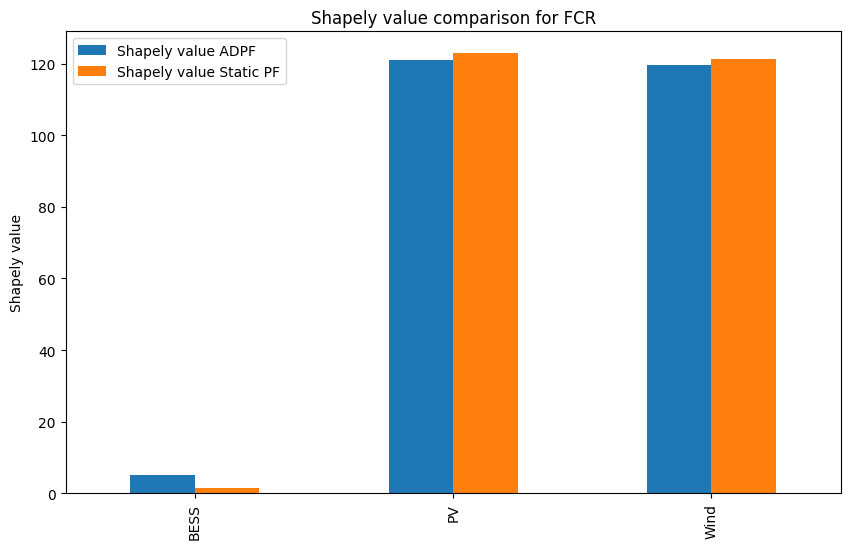

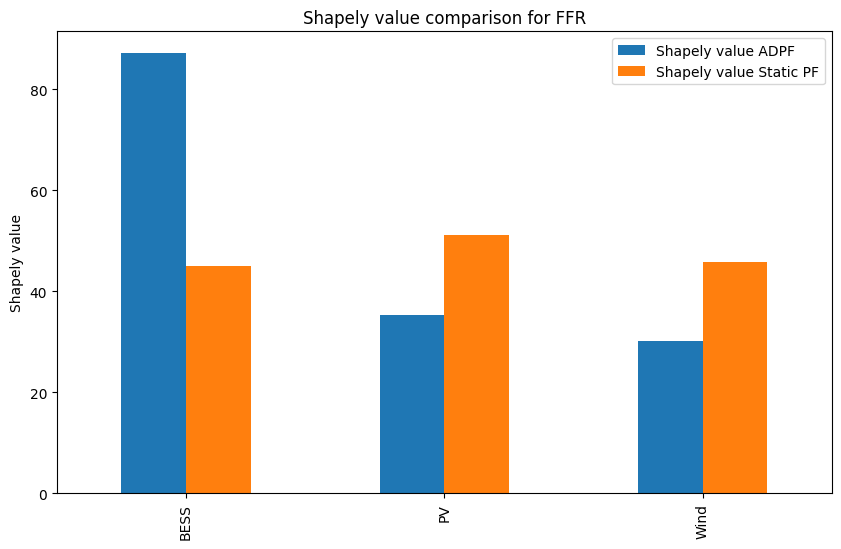

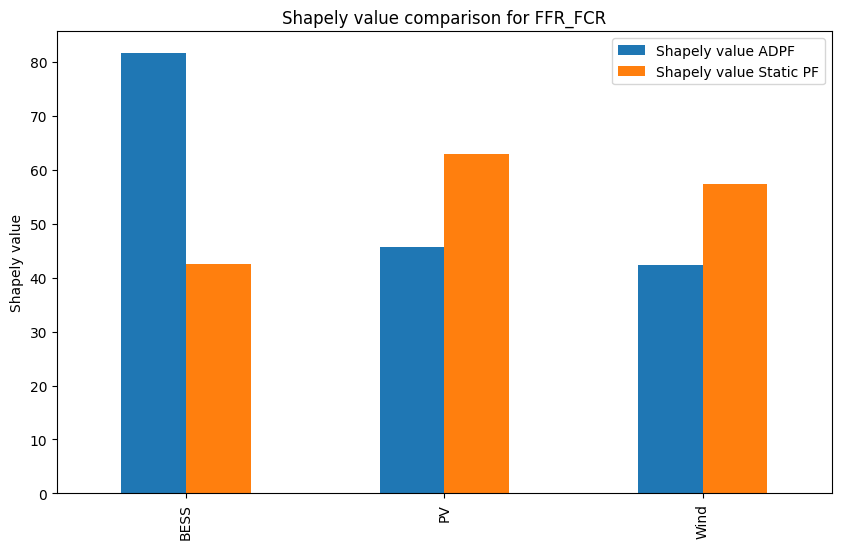

In [26]:
# compare adpf and static pf for shapely values
for service in services:
    df = pd.read_csv(f'{path}/{service}/shapely_value.csv', index_col=0)
    df = df.groupby(df.index).first()
    df = df.transpose()
    df_2 = pd.read_csv(f'{path}/{service}/shapely_value_static_pf.csv', index_col=0)
    df_2 = df_2.groupby(df_2.index).first()
    df_2 = df_2.transpose()

    df = pd.merge(df, df_2, left_index=True, right_index=True, how='outer')
    df.columns = ['Shapely value ADPF', 'Shapely value Static PF']
    df.sort_index(axis=1, inplace=True)
    # change lables
    df.plot(kind='bar', figsize=(10, 6),
            title=f'Shapely value comparison for {service}', ylabel='Shapely value')

In [27]:
import math as mt
import itertools

In [28]:
VS = {'PV': 0, 'Wind': 0, 'BESS': 0, 'SC': 0, 'PV + Wind': 0, 'PV + BESS': 1, 'PV + SC': 1, 'Wind + BESS': 1, 'Wind + SC': 0, 'BESS + SC': 0, 'PV + Wind + BESS': 1, 'PV + Wind + SC': 1.2, 'PV + BESS + SC': 1.2, 'Wind + BESS + SC': 1.2, 'PV + Wind + BESS + SC': 1.6}
VS[()] = 0  # empty coalition

In [29]:
# convert strings to tuples removing spaces and split by +
VS = {tuple(k.replace(' ', '').split('+')): v for k, v in VS.items() if type(k) is str}
VS

{('PV',): 0,
 ('Wind',): 0,
 ('BESS',): 0,
 ('SC',): 0,
 ('PV', 'Wind'): 0,
 ('PV', 'BESS'): 1,
 ('PV', 'SC'): 1,
 ('Wind', 'BESS'): 1,
 ('Wind', 'SC'): 0,
 ('BESS', 'SC'): 0,
 ('PV', 'Wind', 'BESS'): 1,
 ('PV', 'Wind', 'SC'): 1.2,
 ('PV', 'BESS', 'SC'): 1.2,
 ('Wind', 'BESS', 'SC'): 1.2,
 ('PV', 'Wind', 'BESS', 'SC'): 1.6}

In [30]:
VS[()] = 0  # ensure empty coalition is present 

In [31]:
VS

{('PV',): 0,
 ('Wind',): 0,
 ('BESS',): 0,
 ('SC',): 0,
 ('PV', 'Wind'): 0,
 ('PV', 'BESS'): 1,
 ('PV', 'SC'): 1,
 ('Wind', 'BESS'): 1,
 ('Wind', 'SC'): 0,
 ('BESS', 'SC'): 0,
 ('PV', 'Wind', 'BESS'): 1,
 ('PV', 'Wind', 'SC'): 1.2,
 ('PV', 'BESS', 'SC'): 1.2,
 ('Wind', 'BESS', 'SC'): 1.2,
 ('PV', 'Wind', 'BESS', 'SC'): 1.6,
 (): 0}

In [32]:
my_names = ['PV', 'Wind', 'BESS', 'SC']

# Game Theory

## Convexity

In [3]:
import pandas as pd
from src.game_theory_helpers import powerset, is_convex_game, check_convexity_grand_coalition, get_loo, get_shapley_value, get_nash_bargaining_solution

In [4]:
players = ['A', 'B', 'C']
v = {
    (): 0,
    ('A',): 0,
    ('B',): 0,
    ('C',): 0,
    ('A', 'B'): 100,
    ('A', 'C'): 0,
    ('B', 'C'): 0,
    ('A', 'B', 'C'): 200
}
# convert v to frozenset
v_frozen = {frozenset(k): val for k, val in v.items()}

In [5]:
def get_banzhaf_value(v: dict, players: list, normalized=True) -> dict:
    """
    get Banzhaf values for each player

    v: Characteristic function of the game, must be defined for EVERY coalition
        {frozenset -> float}
    players: list of players
    """
    factor = 1 / (2 ** (len(players) - 1))
    banzhaf_values = {p: 0 for p in players}
    for S in powerset(players):
        if S:  # skip 
            for p in S:
                subset_wo_p = frozenset(c for c in S if c != p)
                marginal_contribution = v.get(S) - v.get(subset_wo_p)
                banzhaf_values[p] += marginal_contribution
    banzhaf_values = {k: v * factor for k, v in banzhaf_values.items()}
    if normalized:
        total_banzhaf = sum(banzhaf_values.values())
        reward = v[frozenset(players)]
        if total_banzhaf > 0:
            banzhaf_values = {k: v * (reward / total_banzhaf) for k, v in banzhaf_values.items()}
    return banzhaf_values

In [6]:
v_frozen

{frozenset(): 0,
 frozenset({'A'}): 0,
 frozenset({'B'}): 0,
 frozenset({'C'}): 0,
 frozenset({'A', 'B'}): 100,
 frozenset({'A', 'C'}): 0,
 frozenset({'B', 'C'}): 0,
 frozenset({'A', 'B', 'C'}): 200}

In [7]:
get_banzhaf_value(v_frozen, players)

{'A': 85.71428571428571, 'B': 85.71428571428571, 'C': 28.57142857142857}

In [8]:
# test
is_convex_game(v_frozen, players)
check_convexity_grand_coalition(v_frozen, players)
print(get_loo(v_frozen, players))
print(get_shapley_value(v_frozen, players))
print(get_nash_bargaining_solution(v_frozen, players))

    Grand-Coalition Convexity holds
        Max benefit: 200.00, Min benefit: 100.00
{'A': 80.0, 'B': 80.0, 'C': 40.0}
{'A': 83.33333333333334, 'B': 83.33333333333334, 'C': 33.333333333333336}
{'A': 66.666666738125, 'B': 66.66666673812502, 'C': 66.66666652375004}


In [9]:
def print_2f_dict(d: dict):
    final_print = ''
    for k, v in d.items():
        final_print += f"{k}: {v:.2f}, "
    return final_print

## Define Plot Function

In [49]:
import matplotlib as mpl

In [62]:
# Get the Tab20 colormap
cmap = plt.cm.get_cmap("tab20")

# Extract the first 4 colors
base_colors = [cmap(i) for i in range(8)]

# Create extended cycle: first full alpha, then alpha=0.5
colors = base_colors + [(r, g, b, 0.5) for (r, g, b, _) in base_colors]

# Set this as default color cycle
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors)

C:\Users\carlv\AppData\Local\Temp\ipykernel_34268\2708105729.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab20")


In [63]:
def add_shapely_nbs(df: pd.DataFrame, players: list,
                    add_LOO=False) -> pd.DataFrame:
    """
    Add shapely and nbs values to dataframe df, and optionally LOO

    df: Dataframe with values for each coalition
    players: list of players
    """
    new_index = pd.MultiIndex.from_product((df.index, ['value', 'shapley', 'nbs']))
    if add_LOO:
        new_index = pd.MultiIndex.from_product((df.index, ['value', 'shapley', 'nbs', 'loo']))
    df_new = pd.DataFrame(index=new_index, columns=df.columns)
    for idx, row in df.iterrows():
        df_new.loc[(idx, 'value')] = row
        v = {frozenset(k): val for k, val in row.items()}
        shapley, nbs = get_shapley_value(v, players), get_nash_bargaining_solution(v, players)
        df_new.loc[(idx, 'shapley'), list((k,) for k in shapley.keys())] = list(shapley.values())
        df_new.loc[(idx, 'nbs'), list((k,) for k in nbs.keys())] = list(nbs.values())
        if add_LOO:
            loo = get_loo(v, players)
            df_new.loc[(idx, 'loo'), list((k,) for k in loo.keys())] = list(loo.values())
    return df_new

In [64]:
def visualize_value_results(df_new, df_newstat, calc_convexity=True):
    players = list(str(x[0]) for x in df_new.columns[:3])
    # plot for each service value, shapely and nbs
    for service in df_new.index.get_level_values(0).unique():
        df_plot = df_new.loc[service]
        df_plot = df_plot.astype(float)
        df_plot = df_plot.transpose()
        df_plot.columns = [col + ' Dynamic PF' for col in df_plot.columns]
        # also add df_newstat values
        if df_newstat is not None:
            df_plot_stat = df_newstat.loc[service]
            df_plot_stat = df_plot_stat.astype(float)
            df_plot_stat = df_plot_stat.transpose()
            # remove value column as it is duplicate
            # df_plot_stat = df_plot_stat.loc[:, df_plot_stat.columns != 'value']
            df_plot_stat.columns = [col + ' Static PF' for col in df_plot_stat.columns]
            # combine
            df_plot_total = pd.concat([df_plot, df_plot_stat], axis=1)
        else:
            df_plot_total = df_plot
        df_plot_total = df_plot_total.reindex(sorted(df_plot_total.columns, reverse=True), axis=1)
        # 1st plot: only the players
        df_plot = df_plot_total.iloc[:len(players)]
        ax = df_plot.plot(kind='bar', figsize=(10, 6),
                        title=f'Service: {service} - Individual Value, Shapley and NBS', ylabel='Value in €')
        
        plt.grid()
        plt.ylim(df_plot.min().min(), df_plot.max().max()+3)
        plt.xticks(rotation=0)
        # show numbers above bars
        for p in ax.patches:
            if p.get_height() >= 0:
                ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2, 1.03 * p.get_height()),
                            ha='center', va='bottom', rotation=90, fontsize=10)
        plt.xticks(rotation=45, ha='right')
        plt.show()

        # 2nd plot: all coalitions
        plt.figure()
        df_plot = df_plot_total
        # drop na columns
        df_plot = df_plot.dropna(axis=1, how='any')
        # add convexity where there is  empty coalition
        if calc_convexity:
            v1 = {frozenset(k): val for k, val in df_new.loc[service].loc['value'].items()}
            v1[frozenset()] = 0  # ensure empty coalition is present
            v2 = {frozenset(k): val for k, val in df_newstat.loc[service].loc['value'].items()}
            v2[frozenset()] = 0  # ensure empty coalition is present
            c1 = check_convexity_grand_coalition(v1, players)
            c2 = check_convexity_grand_coalition(v2, players)
            if () in df_plot.index:
                df_plot.loc[(), :] = [c1, c2]  # add convexity results as new row
                df_plot = df_plot.rename(index={(): 'Grand-C Convex Game?'})
            else:
                df_plot = pd.concat([df_plot, pd.DataFrame([[c1], [c2]], columns=['Grand-C Convex Game?'], index=df_plot.columns).T])
        
        
        ax = df_plot.plot(kind='bar', figsize=(10, 6),
                        title=f'Service: {service} - Value of Coalitions', ylabel='Value in €')
        plt.grid()
        plt.xticks(rotation=0)
        # show numbers above bars
        for p in ax.patches:
            if p.get_height() >= 0:
                ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2, 1.03 * p.get_height()),
                            ha='center', va='bottom', rotation=90, fontsize=10)
        plt.xticks(rotation=45, ha='right')
        plt.ylim(0, df_plot.max().max()+3)
        plt.show()


## DVPP1

no stochastic production, just 1MW of PV, Wind, BESS each
IO_dict =      {'PV': (get_pv_sys(), 'lpf', 1),
                'Wind': (get_wind_sys(), 'lpf', 1),
                'BESS': (get_bess_io_sys(t_drop=8), 'hpf', 1),
                }

In [65]:
# load data
# df = pd.read_csv('pics/new/values.csv', index_col=0, header=[0,1,2])
df = pd.read_csv('pics/v1/values_dyn.csv', index_col=0, header=[0,1,2])
df.columns = [tuple(c for c in col if c!='nan') for col in df.columns.values]
players = list(str(x[0]) for x in df.columns[:3])

df[df < 0] = 0  # set values below zero to zero
df

,"(PV,)","(Wind,)","(BESS,)","(PV, Wind)","(PV, BESS)","(Wind, BESS)","(PV, Wind, BESS)",()
FCR,12.3703,12.1389,0.0000,23.3519,12.1389,11.9074,23.8148,0
FFR,1.1316,0.8988,1.5971,1.9140,3.0520,3.0520,5.0565,0
FFR-FCR,4.7321,3.8063,0.0000,7.6125,11.6759,11.9074,20.1114,0
FCR-D,12.6018,12.6018,0.0000,25.2036,12.6018,12.6018,25.2036,0


In [66]:
# also load static pf values
dfstat = pd.read_csv('pics/v1/values_stat.csv', index_col=0, header=[0,1,2])
dfstat.columns = [tuple(c for c in col if c!='nan') for col in dfstat.columns.values]
dfstat[dfstat < 0] = 0  # set values below zero to zero
dfstat

,"(PV,)","(Wind,)","(BESS,)","(PV, Wind)","(PV, BESS)","(Wind, BESS)","(PV, Wind, BESS)",()
FCR,12.3703,12.1389,0.0000,24.2777,6.3523,6.3523,16.8710,0
FFR,1.1316,0.8988,1.5971,2.0303,2.7610,2.4700,4.1254,0
FFR-FCR,4.7321,3.8063,0.0000,8.5383,6.3523,6.3523,16.8710,0
FCR-D,12.6018,12.6018,0.0000,25.2036,7.2782,7.2782,19.6485,0


In [67]:
df_new = add_shapely_nbs(df, players, add_LOO=True)
df_newstat = add_shapely_nbs(dfstat, players, add_LOO=True)

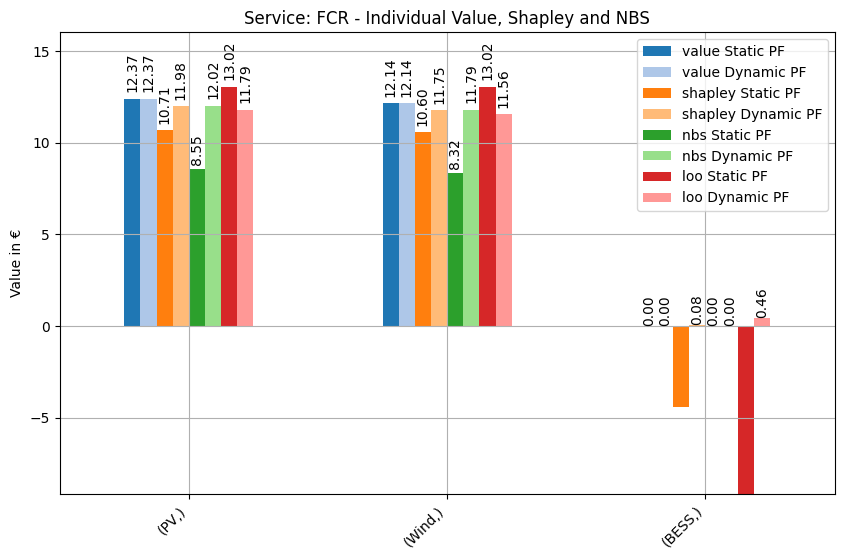

    Game is not Grand-Coalition convex: frozenset({'PV'}), frozenset({'Wind', 'BESS'}), diff=-0.46
    Game is not Grand-Coalition convex: frozenset({'PV'}), frozenset({'Wind', 'BESS'}), diff=-1.85


<Figure size 640x480 with 0 Axes>

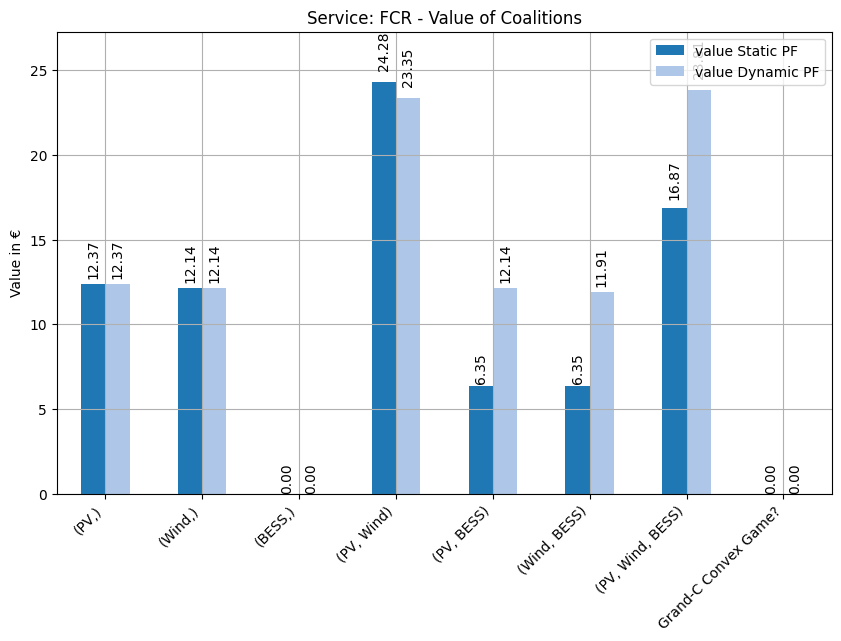

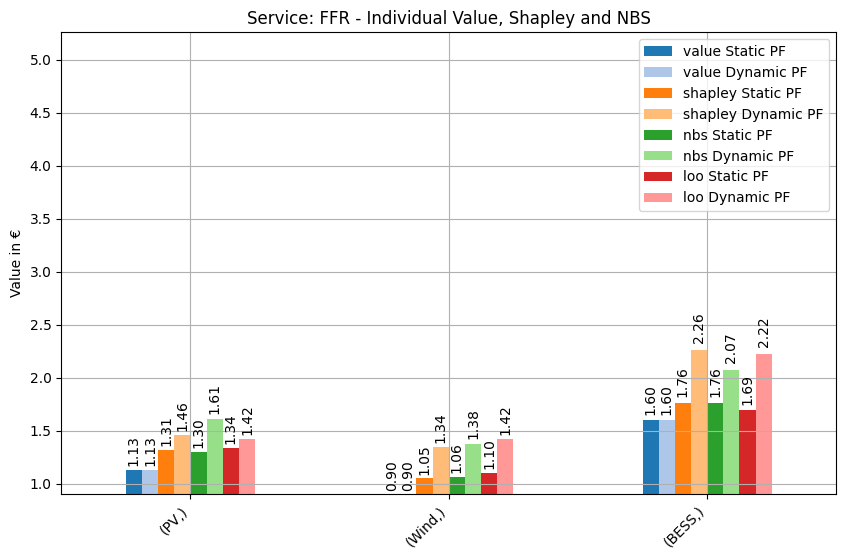

    Grand-Coalition Convexity holds
        Max benefit: 1.55, Min benefit: 0.87
    Grand-Coalition Convexity holds
        Max benefit: 0.52, Min benefit: 0.47


<Figure size 640x480 with 0 Axes>

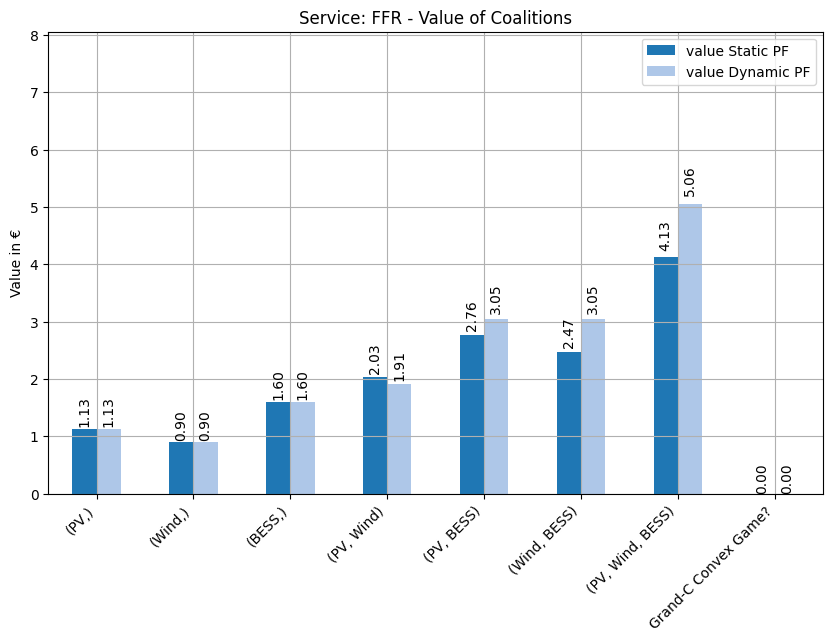

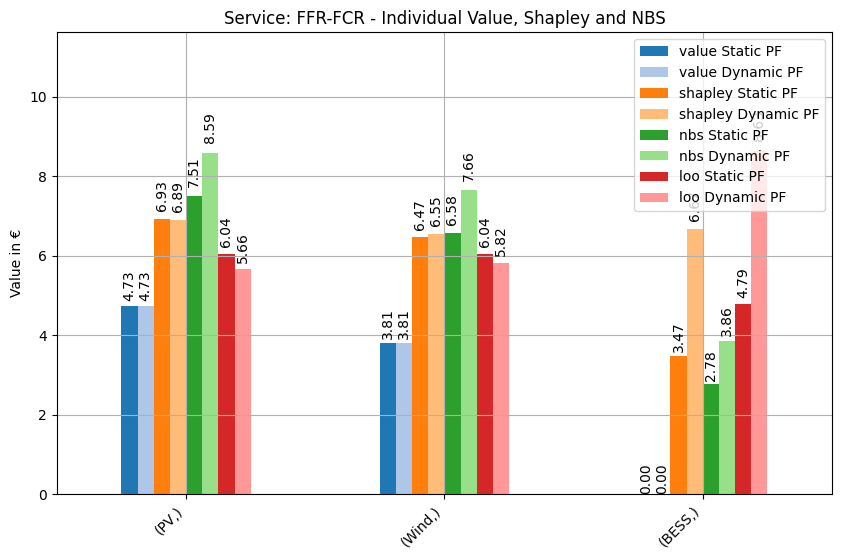

    Grand-Coalition Convexity holds
        Max benefit: 12.50, Min benefit: 3.47
    Grand-Coalition Convexity holds
        Max benefit: 8.33, Min benefit: 5.79


<Figure size 640x480 with 0 Axes>

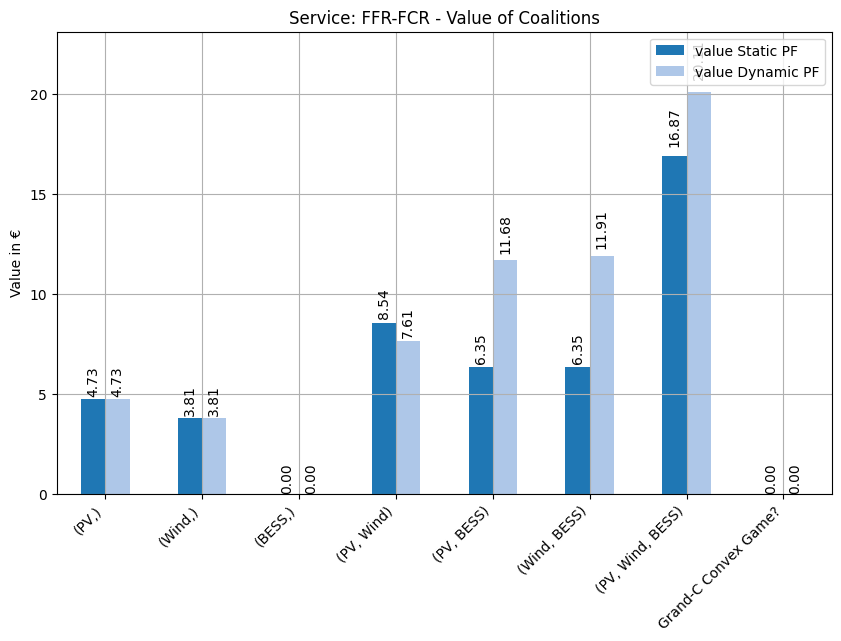

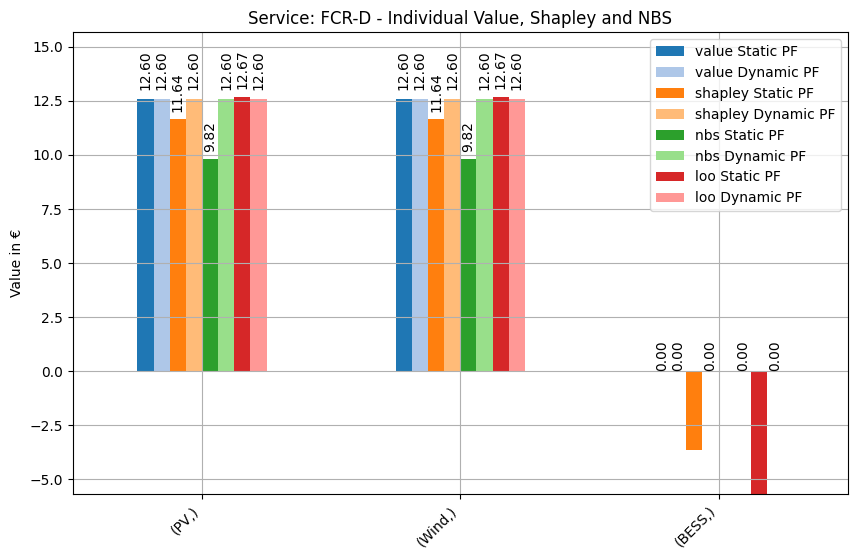

    Grand-Coalition Convexity holds
        Max benefit: 0.00, Min benefit: 0.00
    Game is not Grand-Coalition convex: frozenset({'PV'}), frozenset({'Wind', 'BESS'}), diff=-0.23


<Figure size 640x480 with 0 Axes>

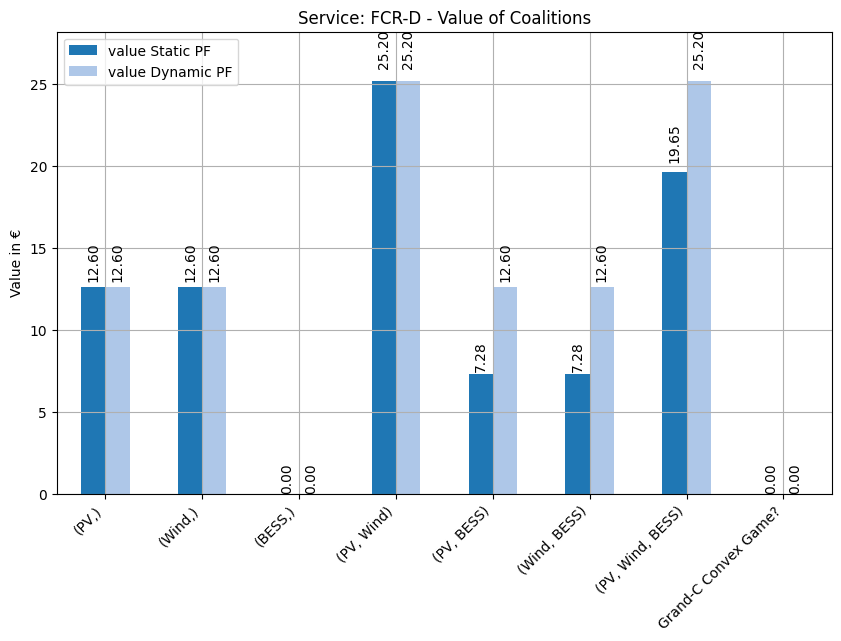

In [68]:
visualize_value_results(df_new, df_newstat)

In [17]:
# compute shapelt value for every row
for idx, row in df.iterrows():
    v = {frozenset(k): val for k, val in row.items()}
    v[frozenset()] = 0  # ensure empty coalition is present
    print(f"{idx} LOO: {print_2f_dict(get_loo(v, players))}")
    print(f"{idx} Shapely values: {print_2f_dict(get_shapley_value(v, players))}")
    print(f"{idx} NBS: {print_2f_dict(get_nash_bargaining_solution(v, players))}")
    is_convex_game(v, players)
    check_convexity_grand_coalition(v, players)

    # compare to static
    v_stat = {frozenset(k): val for k, val in dfstat.loc[idx].items()}
    v_stat[frozenset()] = 0  # ensure empty coalition is present
    print(f"{idx} Static PF Shapely values: {print_2f_dict(get_shapley_value(v_stat, players))}")
    print(f"{idx} Static PF NBS: {print_2f_dict(get_nash_bargaining_solution(v_stat, players))}")
    is_convex_game(v_stat, players)
    check_convexity_grand_coalition(v_stat, players)
    print('---')


FCR LOO: PV: 11.79, Wind: 11.56, BESS: 0.46, 
FCR Shapely values: PV: 11.98, Wind: 11.75, BESS: 0.08, 
FCR NBS: PV: 12.02, Wind: 11.79, BESS: 0.00, 
Game is not convex: frozenset({'PV'}), frozenset({'Wind'})
    Game is not Grand-Coalition convex: frozenset({'PV'}), frozenset({'Wind', 'BESS'}), diff=-0.46
FCR Static PF Shapely values: PV: 10.71, Wind: 10.60, BESS: -4.44, 
FCR Static PF NBS: PV: 8.55, Wind: 8.32, BESS: 0.00, 
Game is not convex: frozenset({'PV'}), frozenset({'Wind'})
    Game is not Grand-Coalition convex: frozenset({'PV'}), frozenset({'Wind', 'BESS'}), diff=-1.85
---
FFR LOO: PV: 1.42, Wind: 1.42, BESS: 2.22, 
FFR Shapely values: PV: 1.46, Wind: 1.34, BESS: 2.26, 
FFR NBS: PV: 1.61, Wind: 1.38, BESS: 2.07, 
Game is not convex: frozenset({'PV'}), frozenset({'Wind'})
    Grand-Coalition Convexity holds
        Max benefit: 1.55, Min benefit: 0.87
FFR Static PF Shapely values: PV: 1.31, Wind: 1.05, BESS: 1.76, 
FFR Static PF NBS: PV: 1.30, Wind: 1.06, BESS: 1.76, 
    Gra

## DVPP2

stochastic production of PV, BESS Wind with 
IO_dict =      {'PV': (get_pv_sys(), 'lpf', 2),
                'Wind': (get_wind_sys(), 'lpf', 1.5),
                'BESS': (get_bess_io_sys(t_drop=8), 'hpf', 1),
                }

In [18]:
# load data
# df = pd.read_csv('pics/new/values.csv', index_col=0, header=[0,1,2])
df = pd.read_csv('pics/v2/values_dyn.csv', index_col=0, header=[0,1,2])
df.columns = [tuple(c for c in col if c!='nan') for col in df.columns.values]

df[df < 0] = 0  # set values below zero to zero
# combine 1st col and index to MultiIndex
df.index = pd.MultiIndex.from_arrays([df.index, df.iloc[:, 0]], names=['Service', 'Scenario'])
df.drop(df.columns[0], axis=1, inplace=True)  # drop first column
players = list(str(x[0]) for x in df.columns[:3])
df.head()

(PV,)   (Wind,)  (BESS,)  (PV, Wind)  (PV, BESS)  \
Service Scenario                                                        
FCR     0         10.27292   5.98447      0.0    15.38167    10.08070   
        1          0.00000   2.75329      0.0     2.69080     0.00000   
        2         10.42807   8.02740      0.0    17.56398    10.23295   
        3         11.33932   7.30694      0.0    17.73109    11.12715   
        4         26.78677  16.34064      0.0    41.00062    26.28556   

                  (Wind, BESS)  (PV, Wind, BESS)  
Service Scenario                                  
FCR     0              5.98447          15.68659  
        1              2.70079           2.74414  
        2              7.87433          17.91217  
        3              7.16761          18.08259  
        4             16.02906          41.81341

In [19]:
# also load static pf values
dfstat = pd.read_csv('pics/v2/values_stat.csv', index_col=0, header=[0,1,2])
dfstat.columns = [tuple(c for c in col if c!='nan') for col in dfstat.columns.values]
players = list(dfstat.columns[-2])
dfstat[dfstat < 0] = 0  # set values below zero to zero
# combine 1st col and index to MultiIndex
dfstat.index = pd.MultiIndex.from_arrays([dfstat.index, df.iloc[:, 0]], names=['Service', 'Scenario'])
dfstat.drop(dfstat.columns[0], axis=1, inplace=True)  # drop first column
players = list(str(x[0]) for x in dfstat.columns[:3])
dfstst_mean = dfstat.groupby(level=0).mean()

In [20]:
# mean over all scenarios
df_mean = df.groupby('Service').mean()
# check for convexity, shapely and nbs for mean values
for idx, row in df_mean.iterrows():
    v = {frozenset(k): val for k, val in row.items()}
    v[frozenset()] = 0  # ensure empty coalition is present
    print(f"{idx} Shapely values: {print_2f_dict(get_shapley_value(v, players))}")
    print(f"{idx} NBS: {print_2f_dict(get_nash_bargaining_solution(v, players))}")
    is_convex_game(v, players)
    check_convexity_grand_coalition(v, players)

FCR Shapely values: PV: 9.33, Wind: 6.81, BESS: 0.06, 
FCR NBS: PV: 9.38, Wind: 6.82, BESS: 0.00, 
Game is not convex: frozenset({'PV'}), frozenset({'Wind'})
    Game is not Grand-Coalition convex: frozenset({'PV'}), frozenset({'Wind', 'BESS'}), diff=-0.36
FCR-D Shapely values: PV: 9.81, Wind: 7.34, BESS: 0.00, 
FCR-D NBS: PV: 9.81, Wind: 7.34, BESS: 0.00, 
    Grand-Coalition Convexity holds
        Max benefit: 0.00, Min benefit: -0.02
FFR Shapely values: PV: 4.10, Wind: 3.13, BESS: 5.85, 
FFR NBS: PV: 4.48, Wind: 3.54, BESS: 5.04, 
Game is not convex: frozenset({'PV'}), frozenset({'Wind'})
    Grand-Coalition Convexity holds
        Max benefit: 3.72, Min benefit: 1.28
FFR-FCR Shapely values: PV: 4.94, Wind: 3.18, BESS: 3.86, 
FFR-FCR NBS: PV: 5.72, Wind: 4.23, BESS: 2.03, 
Game is not convex: frozenset({'PV'}), frozenset({'Wind'})
    Grand-Coalition Convexity holds
        Max benefit: 6.57, Min benefit: 0.81


In [21]:
df_new = add_shapely_nbs(df_mean, players)
df_newstat = add_shapely_nbs(dfstst_mean, players)

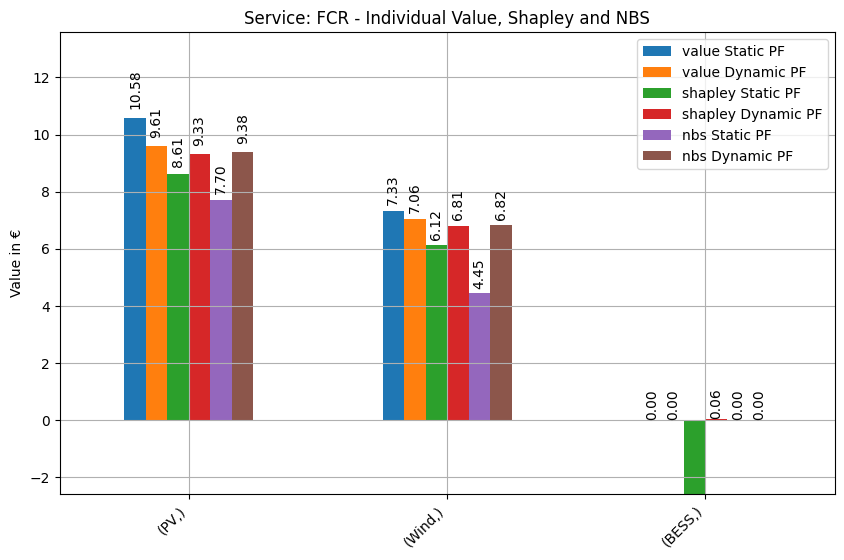

    Game is not Grand-Coalition convex: frozenset({'PV'}), frozenset({'Wind', 'BESS'}), diff=-0.36
    Game is not Grand-Coalition convex: frozenset({'PV'}), frozenset({'Wind', 'BESS'}), diff=-2.29


<Figure size 640x480 with 0 Axes>

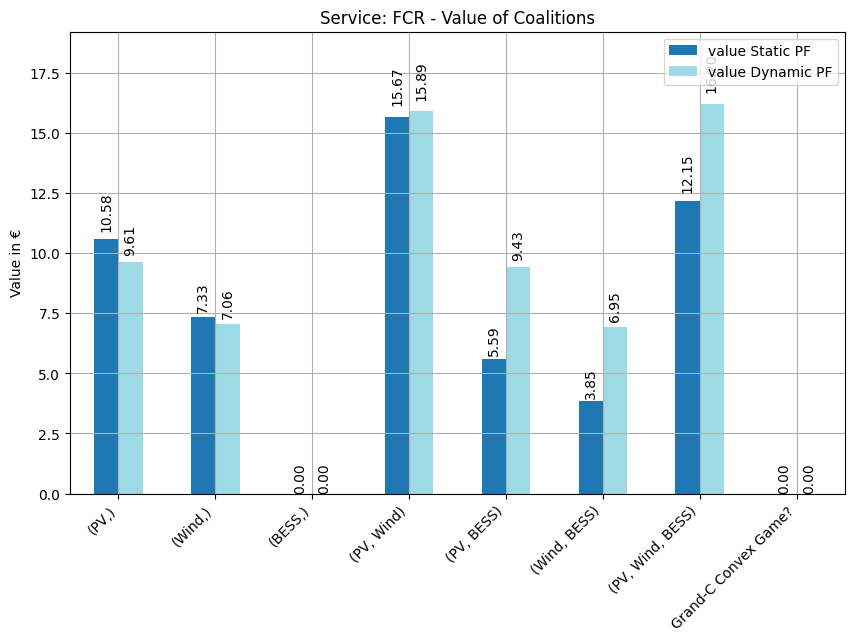

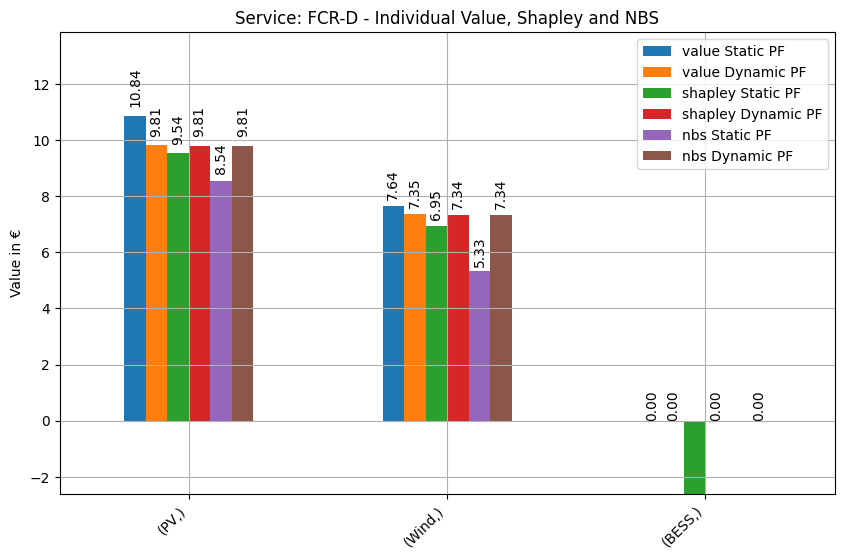

    Grand-Coalition Convexity holds
        Max benefit: 0.00, Min benefit: -0.02
    Game is not Grand-Coalition convex: frozenset({'PV'}), frozenset({'Wind', 'BESS'}), diff=-1.38


<Figure size 640x480 with 0 Axes>

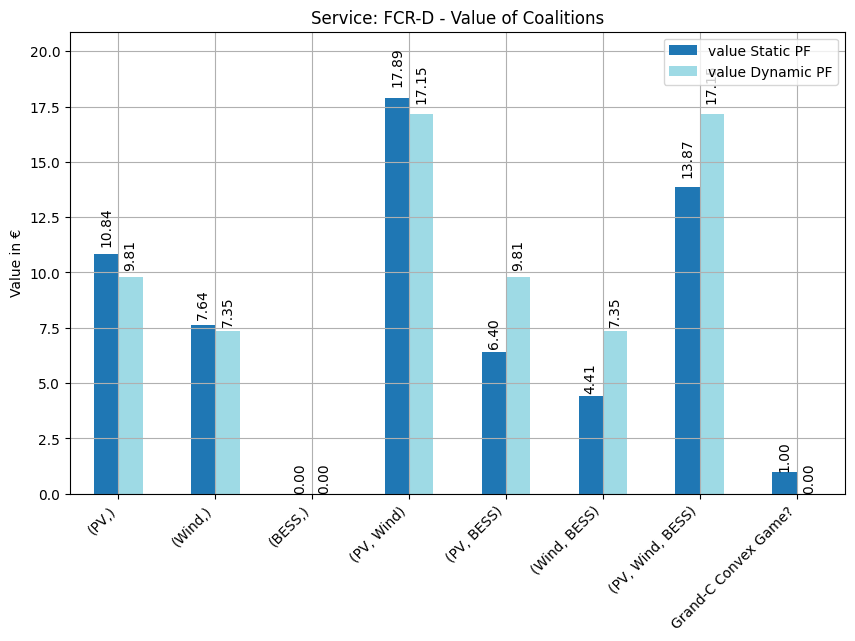

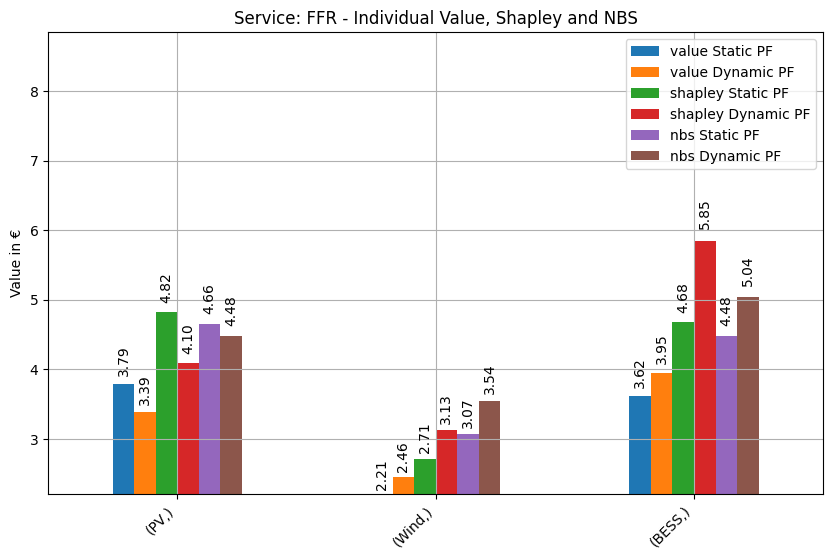

    Grand-Coalition Convexity holds
        Max benefit: 3.72, Min benefit: 1.28
    Grand-Coalition Convexity holds
        Max benefit: 2.42, Min benefit: 1.32


<Figure size 640x480 with 0 Axes>

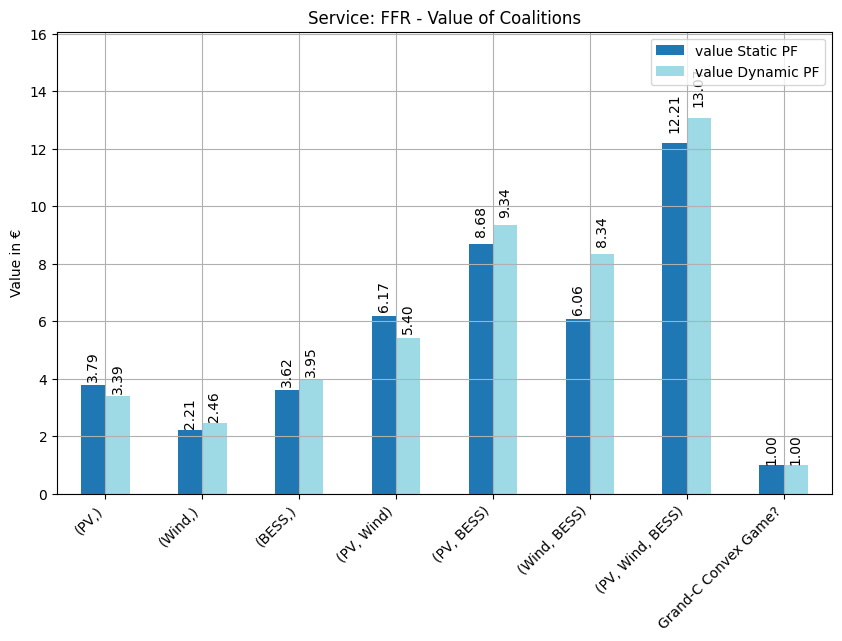

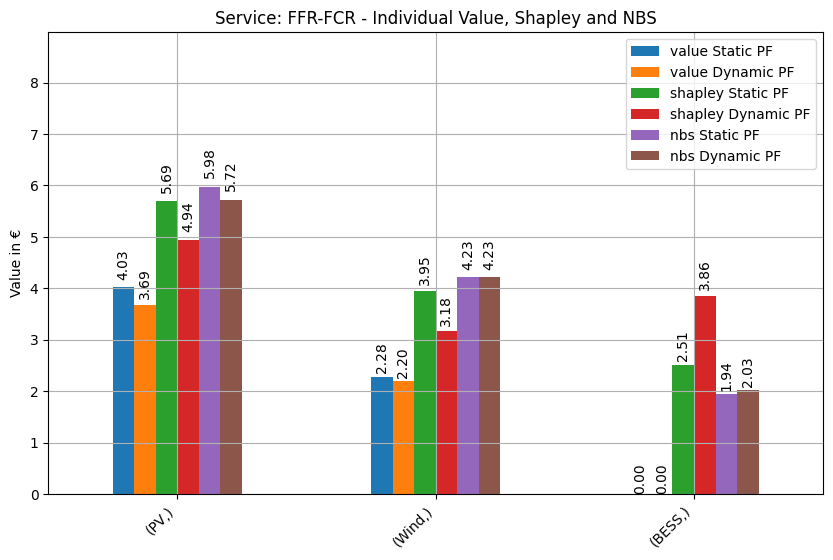

    Grand-Coalition Convexity holds
        Max benefit: 6.57, Min benefit: 0.81
    Grand-Coalition Convexity holds
        Max benefit: 5.97, Min benefit: 4.26


<Figure size 640x480 with 0 Axes>

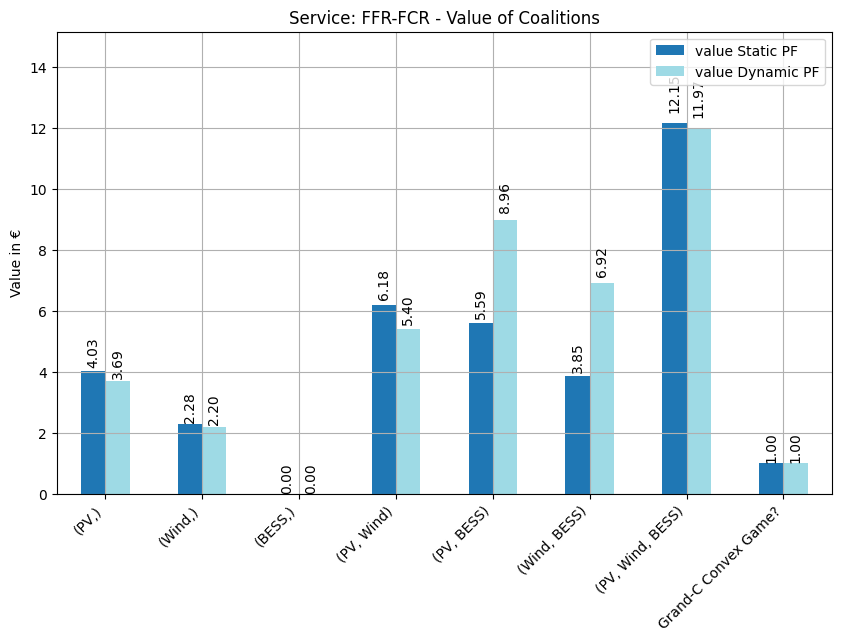

In [22]:
# visualize:
visualize_value_results(df_new, df_newstat)

## DVPP3

no stochastic production, 1MW of
IO_dict =     {'Hydro': (get_hydro_tf(), 'lpf', 1),
                'BESS': (get_bess_io_sys(t_drop=8), 'bpf', 1),
                'SC': (get_sc_io_sys(t_drop=5), 'hpf', 1),
                }

In [23]:
# load data
df = pd.read_csv('pics/v3/values_dyn.csv', index_col=0, header=[0,1,2])
df.columns = [tuple(c for c in col if c!='nan') for col in df.columns.values]
players = [str(x[0]) for x in df.columns[:3]]
df[df < 0] = 0  # set values below zero to zero
df

,"(Hydro,)","(BESS,)","(SC,)","(Hydro, BESS)","(Hydro, SC)","(BESS, SC)","(Hydro, BESS, SC)"
FCR,0.0,0.00000,0.00000,2.41748,1.26018,0.00000,2.41748
FFR,0.0,1.59712,0.84059,2.99379,1.48073,3.16838,2.99379
FFR-FCR,0.0,0.00000,0.00000,3.57479,3.34333,0.00000,3.57479
FCR-D,0.0,0.00000,0.00000,4.50064,2.41748,0.00000,4.50064


In [24]:
# also load static pf values
dfstat = pd.read_csv('pics/v3/values_stat.csv', index_col=0, header=[0,1,2])
dfstat.columns = [tuple(c for c in col if c!='nan') for col in dfstat.columns.values]
players_stat = players
dfstat[dfstat < 0] = 0  # set values below zero to zero
dfstat

,"(Hydro,)","(BESS,)","(SC,)","(Hydro, BESS)","(Hydro, SC)","(BESS, SC)","(Hydro, BESS, SC)"
FCR,0.0,0.00000,0.00000,6.35233,6.12086,0.00000,4.26917
FFR,0.0,1.59712,0.84059,1.24795,1.24795,2.41185,1.88809
FFR-FCR,0.0,0.00000,0.00000,4.96356,3.80625,0.00000,3.80625
FCR-D,0.0,0.00000,0.00000,7.27817,7.04671,0.00000,4.96356


In [25]:
# check convexity
for idx, row in df.iterrows():
    v = {frozenset(k): val for k, val in row.items()}
    v[frozenset()] = 0  # ensure empty coalition is present
    print(f"{idx} Shapely values: {print_2f_dict(get_shapley_value(v, players))}")
    print(f"{idx} NBS: {print_2f_dict(get_nash_bargaining_solution(v, players))}")
    is_convex_game(v, players)
    check_convexity_grand_coalition(v, players)

    # compare to static
    v_stat = {frozenset(k): val for k, val in dfstat.loc[idx].items()}
    v_stat[frozenset()] = 0  # ensure empty coalition is present
    print(f"{idx} Static PF Shapely values: {print_2f_dict(get_shapley_value(v_stat, players_stat))}")
    print(f"{idx} Static PF NBS: {print_2f_dict(get_nash_bargaining_solution(v_stat, players_stat))}")
    is_convex_game(v_stat, players_stat)
    check_convexity_grand_coalition(v_stat, players_stat)
    print('---')

FCR Shapely values: Hydro: 1.42, BESS: 0.79, SC: 0.21, 
FCR NBS: Hydro: 0.81, BESS: 0.81, SC: 0.81, 
Game is not convex: frozenset({'Hydro', 'BESS'}), frozenset({'Hydro', 'SC'})
    Grand-Coalition Convexity holds
        Max benefit: 2.42, Min benefit: 0.00
FCR Static PF Shapely values: Hydro: 3.50, BESS: 0.44, SC: 0.33, 
FCR Static PF NBS: Hydro: 1.42, BESS: 1.42, SC: 1.42, 
Game is not convex: frozenset({'BESS'}), frozenset({'Hydro', 'SC'})
    Game is not Grand-Coalition convex: frozenset({'BESS'}), frozenset({'Hydro', 'SC'}), diff=-1.85
---
FFR Shapely values: Hydro: 0.28, BESS: 1.92, SC: 0.79, 
FFR NBS: Hydro: 0.19, BESS: 1.78, SC: 1.03, 
Game is not convex: frozenset({'Hydro'}), frozenset({'SC', 'BESS'})
    Game is not Grand-Coalition convex: frozenset({'Hydro'}), frozenset({'BESS', 'SC'}), diff=-0.17
FFR Static PF Shapely values: Hydro: -0.16, BESS: 1.22, SC: 0.84, 
FFR Static PF NBS: Hydro: -0.27, BESS: 1.32, SC: 0.84, 
Game is not convex: frozenset({'Hydro'}), frozenset({'BE

In [26]:
df_new = add_shapely_nbs(df, players)
df_newstat = add_shapely_nbs(dfstat, players)

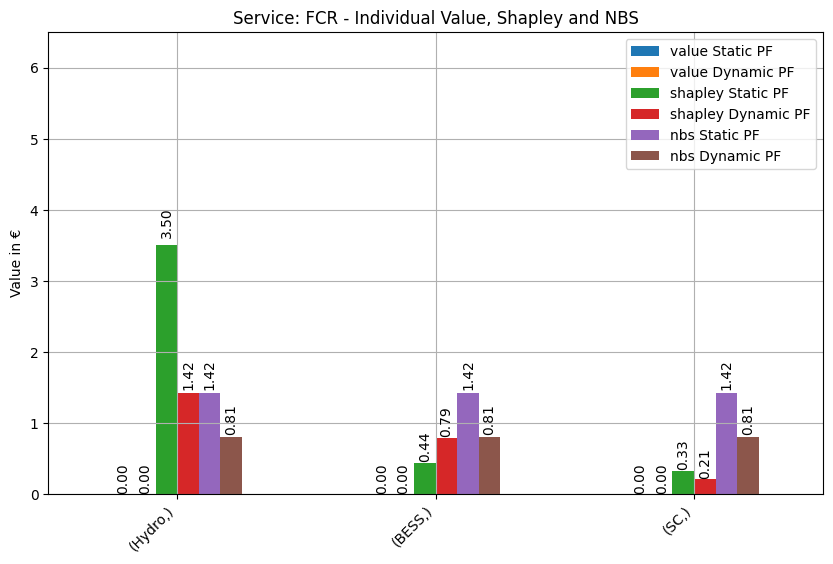

    Grand-Coalition Convexity holds
        Max benefit: 2.42, Min benefit: 0.00
    Game is not Grand-Coalition convex: frozenset({'BESS'}), frozenset({'Hydro', 'SC'}), diff=-1.85


<Figure size 640x480 with 0 Axes>

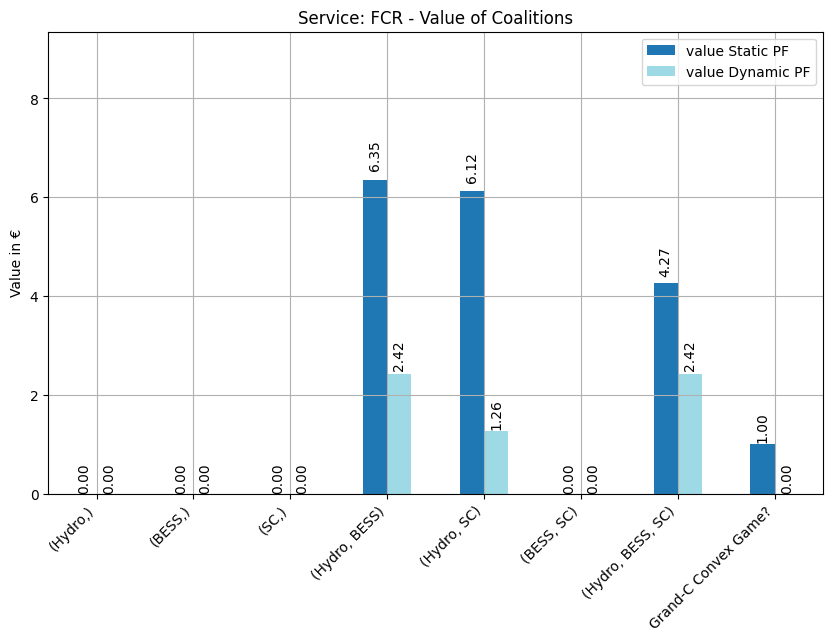

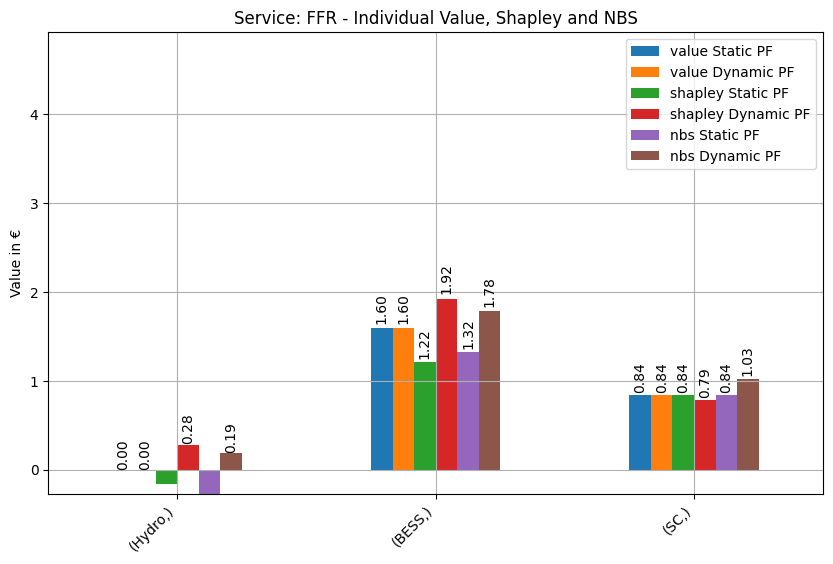

    Game is not Grand-Coalition convex: frozenset({'Hydro'}), frozenset({'BESS', 'SC'}), diff=-0.17
    Game is not Grand-Coalition convex: frozenset({'Hydro'}), frozenset({'BESS', 'SC'}), diff=-0.52


<Figure size 640x480 with 0 Axes>

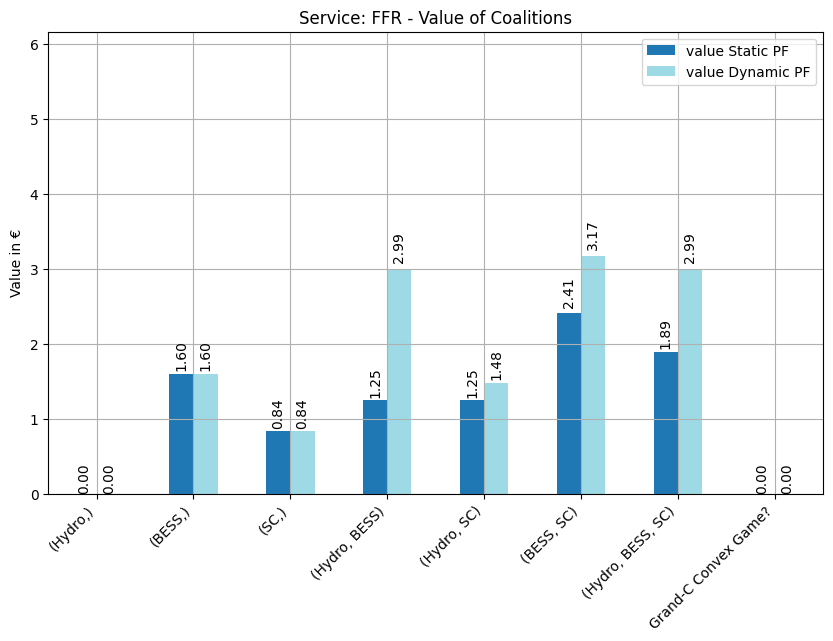

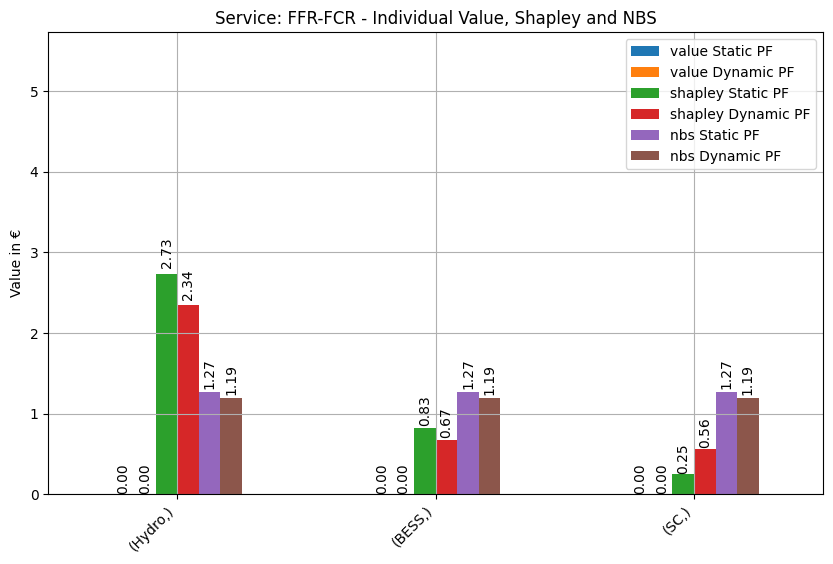

    Grand-Coalition Convexity holds
        Max benefit: 3.57, Min benefit: 0.00
    Game is not Grand-Coalition convex: frozenset({'SC'}), frozenset({'Hydro', 'BESS'}), diff=-1.16


<Figure size 640x480 with 0 Axes>

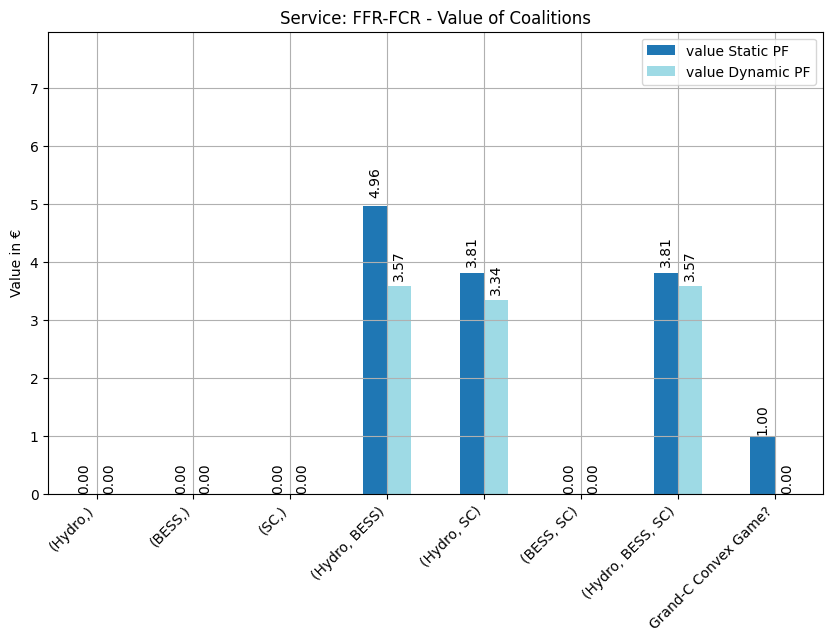

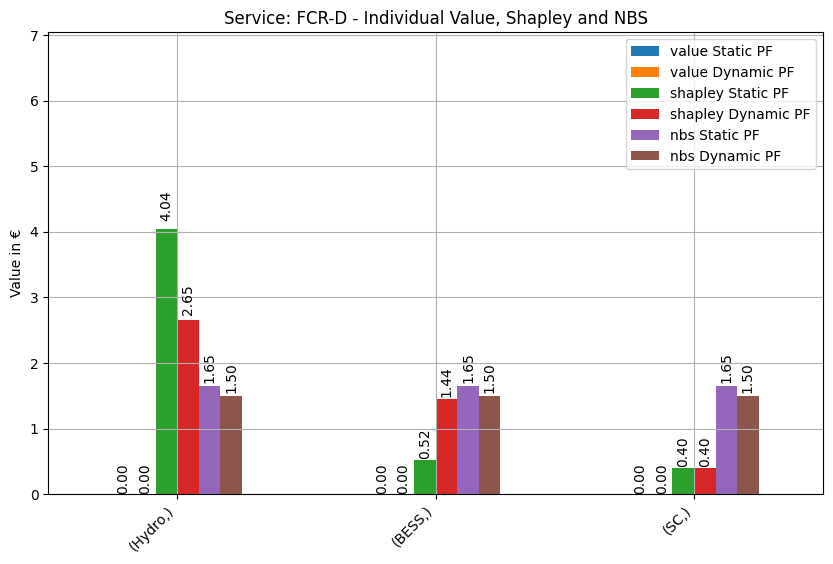

    Grand-Coalition Convexity holds
        Max benefit: 4.50, Min benefit: 0.00
    Game is not Grand-Coalition convex: frozenset({'BESS'}), frozenset({'Hydro', 'SC'}), diff=-2.08


<Figure size 640x480 with 0 Axes>

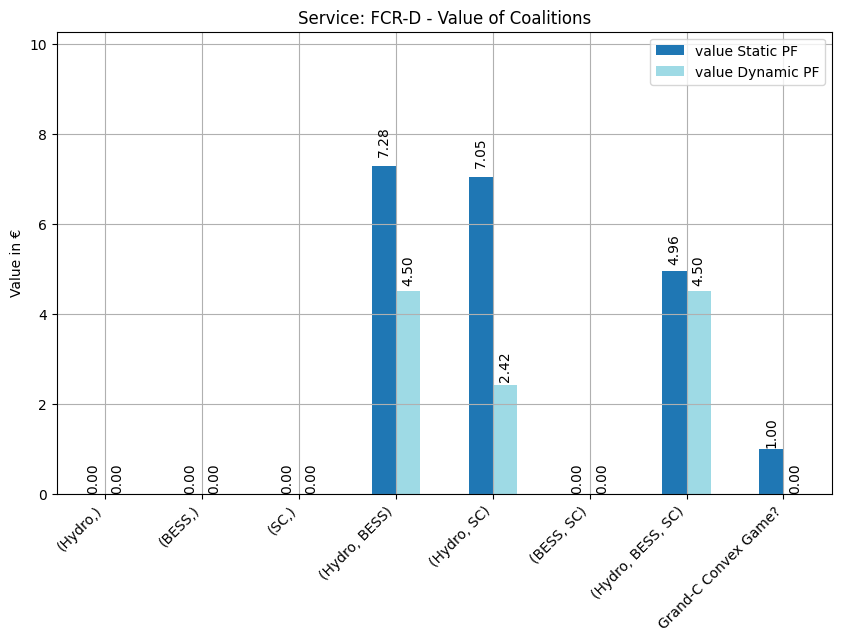

In [27]:
visualize_value_results(df_new, df_newstat)

## DVPP2A

Using adpative dynamic PF (ADPF) with setttings 

run simulation with default parameters
    def get_io_dict():
        return {'PV': (get_pv_sys(), 'lpf', 1),
                'Wind': (get_wind_sys(), 'lpf', 1),
                'BESS': (get_bess_energy_sys(e_max=1.8), 'hpf', 1),
                }
    
    def adaptive_pv_func(t):
        return np.sin(t / 5)**2
    
    def adaptive_wind_func(t):
        return np.cos(t / 5)**2

In [28]:
# load data
df = pd.read_csv('pics/v2A/values_dyn.csv', index_col=0, header=[0,1,2])
df.columns = [tuple(c for c in col if c!='nan') for col in df.columns.values]

df[df < 0] = 0  # set values below zero to zero
df

,"(PV,)","(Wind,)","(BESS,)","(PV, Wind)","(PV, BESS)","(Wind, BESS)","(PV, Wind, BESS)"
FCR,3.57479,3.57479,0.00000,11.31588,12.13886,11.67593,17.79680
FFR,1.01517,0.89878,3.16838,1.09923,3.11018,3.11018,4.24174
FFR-FCR,3.57479,3.57479,0.00000,4.37205,12.13886,3.57479,16.87095
FCR-D,4.26917,4.26917,0.00000,14.09342,5.19502,4.26917,21.03726


In [29]:
df_stat = pd.read_csv('pics/v2A/values_stat.csv', index_col=0, header=[0,1,2])
df_stat.columns = [tuple(c for c in col if c!='nan') for col in df_stat.columns.values]

df_stat[df_stat < 0] = 0  # set values below zero to zero
df_stat

,"(PV,)","(Wind,)","(BESS,)","(PV, Wind)","(PV, BESS)","(Wind, BESS)","(PV, Wind, BESS)"
FCR,3.57479,3.57479,0.00000,11.31588,3.11187,1.72310,8.07543
FFR,1.01517,0.89878,3.16838,1.09923,1.71351,1.94629,2.72868
FFR-FCR,3.57479,3.57479,0.00000,4.37205,1.72310,1.72310,8.07543
FCR-D,4.26917,4.26917,0.00000,14.09342,2.18602,2.18602,9.00127


In [30]:
players = list(str(x[0]) for x in df.columns[:3])

In [31]:
df_new = add_shapely_nbs(df, players, add_LOO=True)
df_newstat = add_shapely_nbs(df_stat, players, add_LOO=True)

In [32]:
# check convexity
for idx, row in df.iterrows():
    v = {frozenset(k): val for k, val in row.items()}
    v[frozenset()] = 0  # ensure empty coalition is present
    # print(f"{idx} LOO: {print_2f_dict(get_loo(v, players))}")
    # print(f"{idx} Shapely values: {print_2f_dict(get_shapley_value(v, players))}")
    # print(f"{idx} NBS: {print_2f_dict(get_nash_bargaining_solution(v, players))}")
    print(f"{idx} - Convexity")
    is_convex_game(v, players)
    check_convexity_grand_coalition(v, players)

FCR - Convexity
Game is not convex: frozenset({'PV', 'Wind'}), frozenset({'PV', 'BESS'})
    Grand-Coalition Convexity holds
        Max benefit: 6.48, Min benefit: 2.08
FFR - Convexity
Game is not convex: frozenset({'PV'}), frozenset({'Wind'})
    Grand-Coalition Convexity holds
        Max benefit: 0.23, Min benefit: -0.03
FFR-FCR - Convexity
Game is not convex: frozenset({'PV'}), frozenset({'Wind'})
    Grand-Coalition Convexity holds
        Max benefit: 12.50, Min benefit: 1.16
FCR-D - Convexity
    Grand-Coalition Convexity holds
        Max benefit: 12.50, Min benefit: 6.94


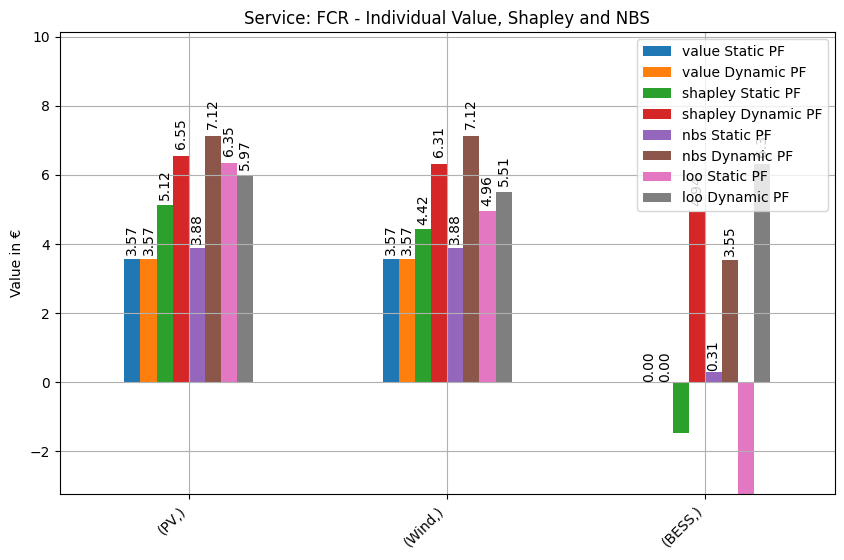

    Grand-Coalition Convexity holds
        Max benefit: 6.48, Min benefit: 2.08
    Game is not Grand-Coalition convex: frozenset({'BESS'}), frozenset({'PV', 'Wind'}), diff=-3.24


<Figure size 640x480 with 0 Axes>

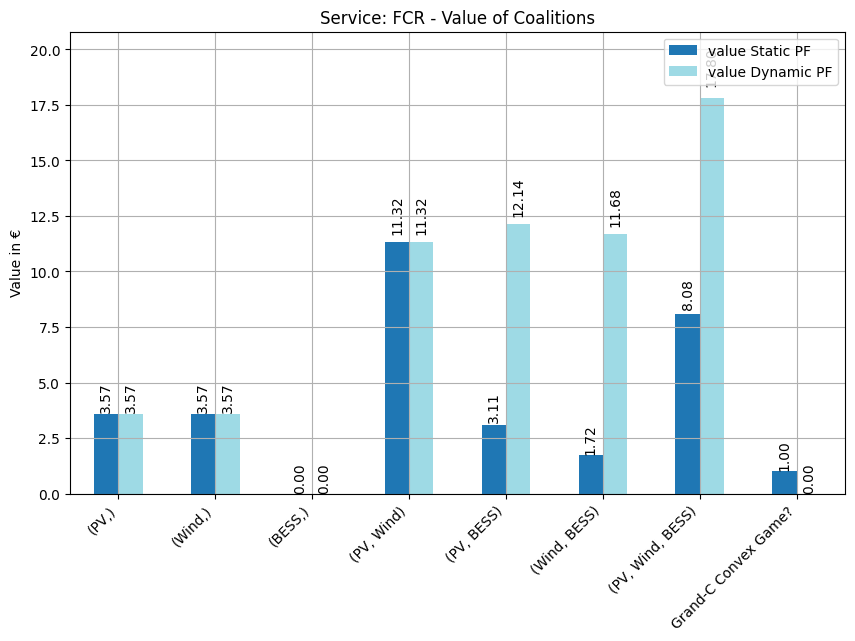

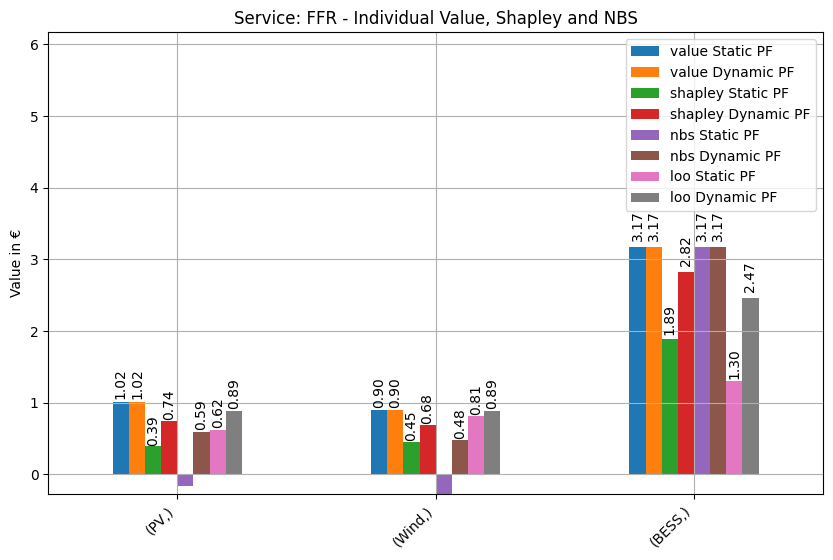

    Grand-Coalition Convexity holds
        Max benefit: 0.23, Min benefit: -0.03
    Game is not Grand-Coalition convex: frozenset({'PV'}), frozenset({'Wind', 'BESS'}), diff=-0.23


<Figure size 640x480 with 0 Axes>

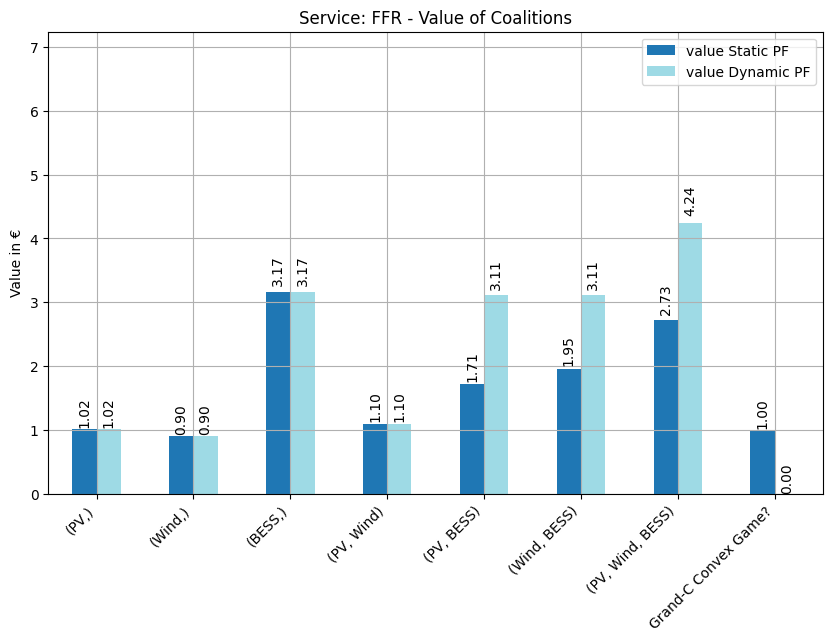

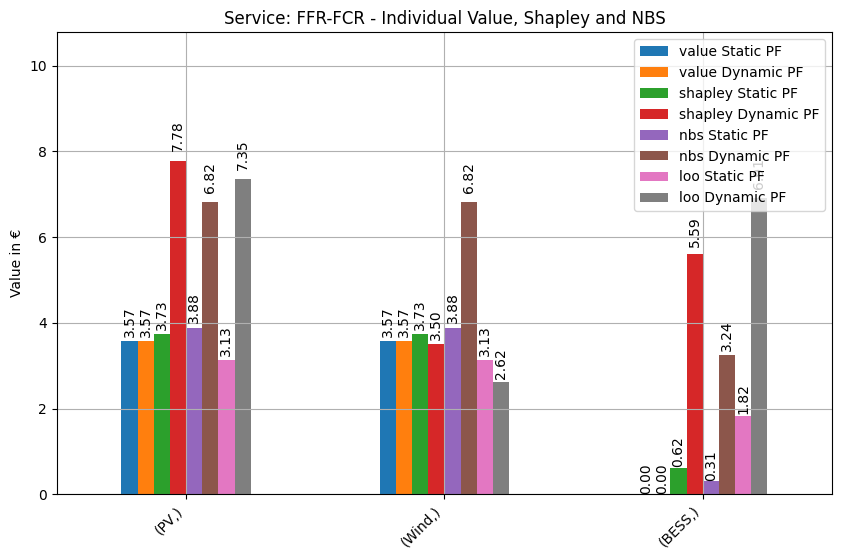

    Grand-Coalition Convexity holds
        Max benefit: 12.50, Min benefit: 1.16
    Grand-Coalition Convexity holds
        Max benefit: 3.70, Min benefit: 2.78


<Figure size 640x480 with 0 Axes>

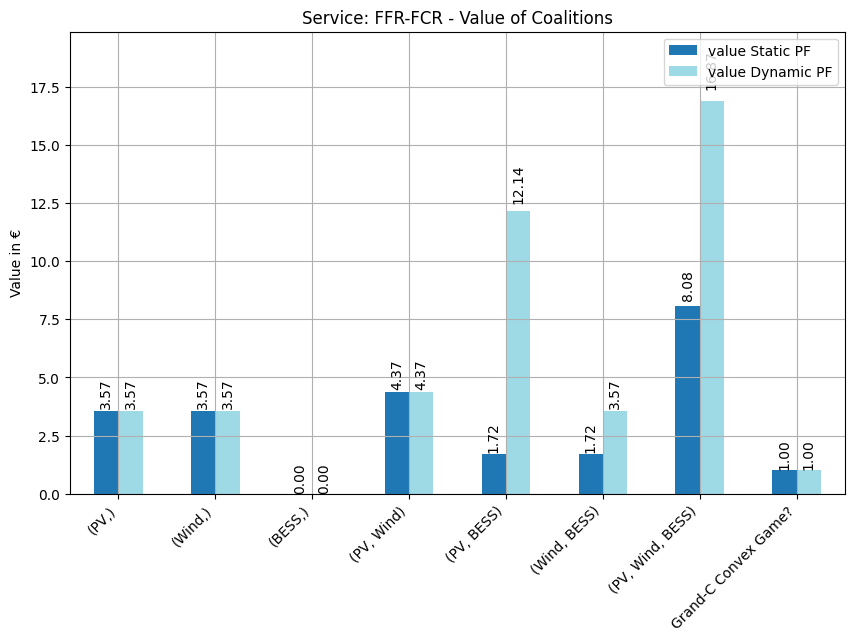

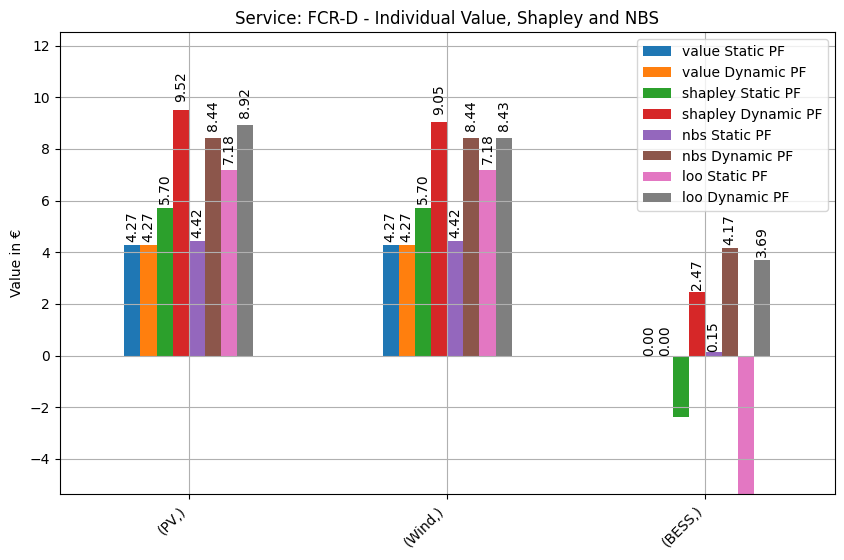

    Grand-Coalition Convexity holds
        Max benefit: 12.50, Min benefit: 6.94
    Game is not Grand-Coalition convex: frozenset({'BESS'}), frozenset({'PV', 'Wind'}), diff=-5.09


<Figure size 640x480 with 0 Axes>

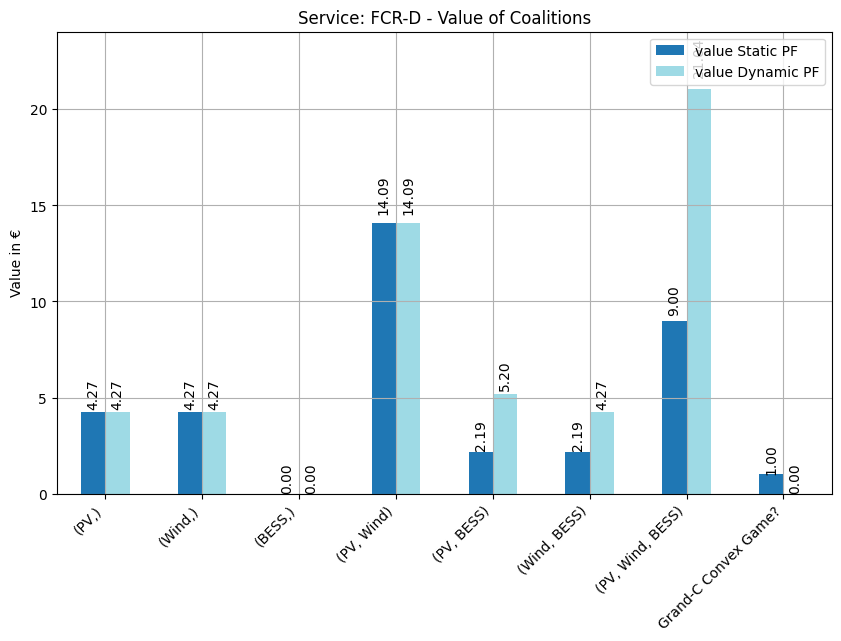

In [33]:
visualize_value_results(df_new, df_newstat)